### Imports

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import difflib
import numpy as np
from sklearn.impute import KNNImputer
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

### 2. Marco Teórico

El marco teórico de este proyecto abarca varios conceptos clave relacionados con el procesamiento y análisis de datos de series temporales, así como el empleo de modelos estadísticos y de aprendizaje automático para realizar pronósticos. A continuación, se detalla cada uno de estos conceptos.

#### 2.1 Procesamiento de Datos

El tratamiento adecuado de los datos es fundamental para garantizar la validez y la fiabilidad de los resultados obtenidos. Este proceso incluye varias etapas:

CO columns: ['DATE TIME', 'BELISARIO', 'CARAPUNGO', 'CENTRO', 'COTOCOLLAO', 'EL CAMAL', 'GUAMANI']
DIR columns: ['DATE TIME', 'BELISARIO', 'CARAPUNGO', 'COTOCOLLAO', 'EL CAMAL', 'LOS CHILLOS', 'TUMBACO']
HUM columns: ['DATE TIME', 'BELISARIO', 'CARAPUNGO', 'COTOCOLLAO', 'EL CAMAL', 'LOS CHILLOS', 'TUMBACO']
LLU columns: ['DATE TIME', 'BELISARIO', 'CARAPUNGO', 'COTOCOLLAO', 'EL CAMAL', 'GUAMANI', 'LOS CHILLOS', 'SAN ANTONIO', 'TUMBACO']
NO2 columns: ['DATE TIME', 'BELISARIO', 'CARAPUNGO', 'CENTRO', 'COTOCOLLAO', 'EL CAMAL', 'GUAMANI', 'LOS CHILLOS']
O3 columns: ['DATE TIME', 'BELISARIO', 'CARAPUNGO', 'CENTRO', 'COTOCOLLAO', 'EL CAMAL', 'GUAMANI', 'LOS CHILLOS', 'TUMBACO']
PM10 columns: ['DATE TIME', 'CARAPUNGO', 'GUAMANI', 'SAN ANTONIO']
PM2.5 columns: ['DATE TIME', 'BELISARIO', 'CARAPUNGO', 'CENTRO', 'COTOCOLLAO', 'EL CAMAL', 'SAN ANTONIO']
PRE columns: ['DATE TIME', 'BELISARIO', 'CARAPUNGO', 'COTOCOLLAO', 'EL CAMAL', 'LOS CHILLOS', 'SAN ANTONIO', 'TUMBACO']
RS columns: ['DATE TIME', '

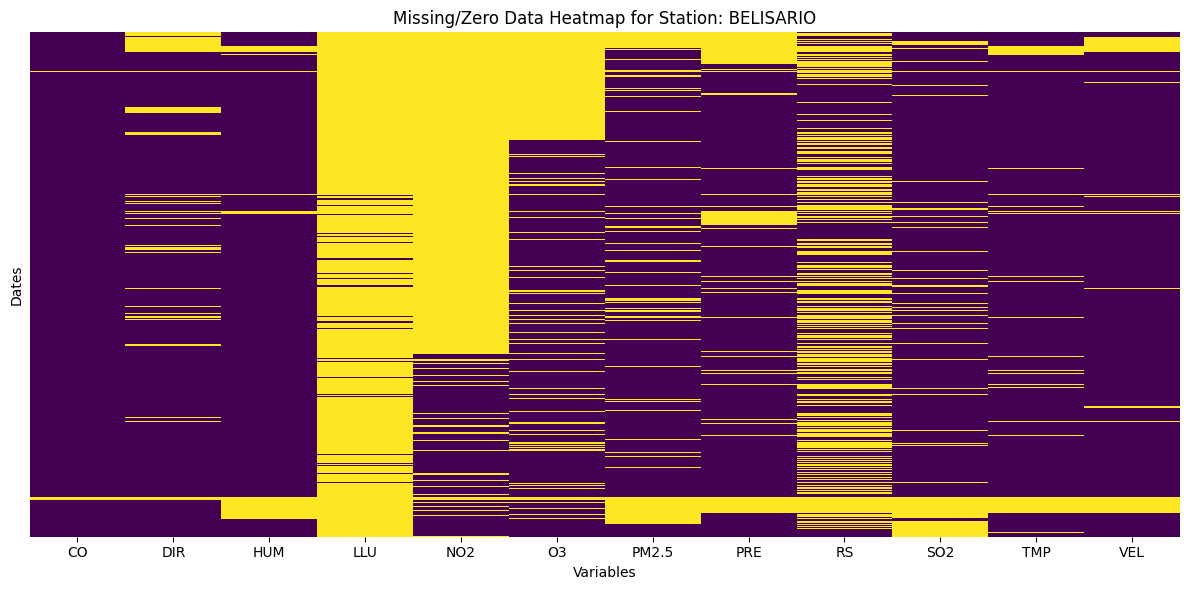

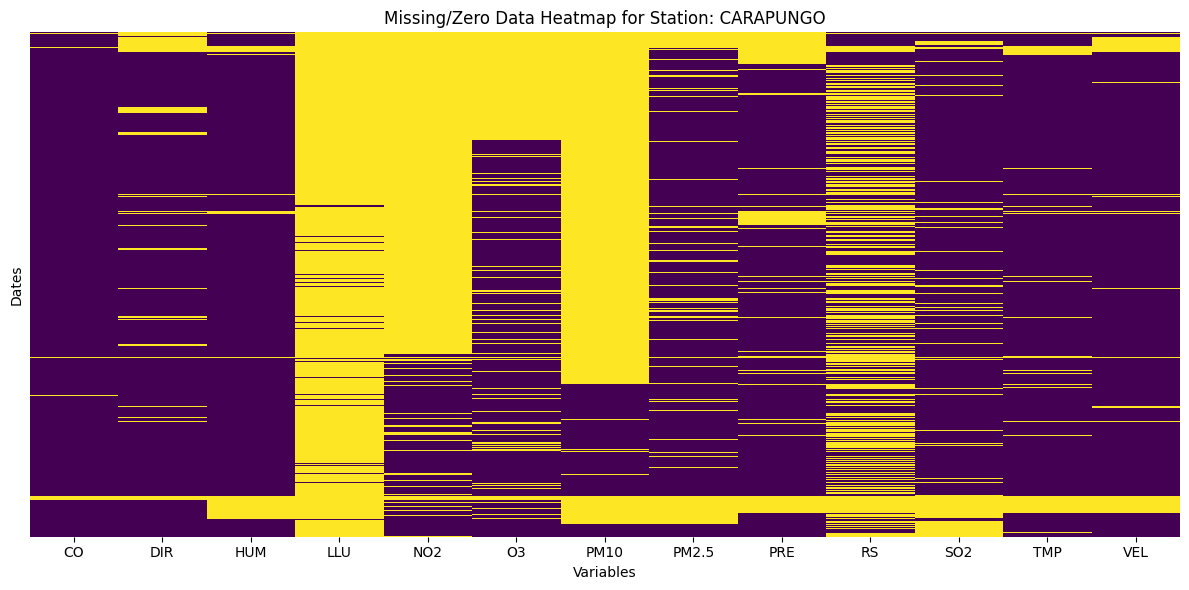

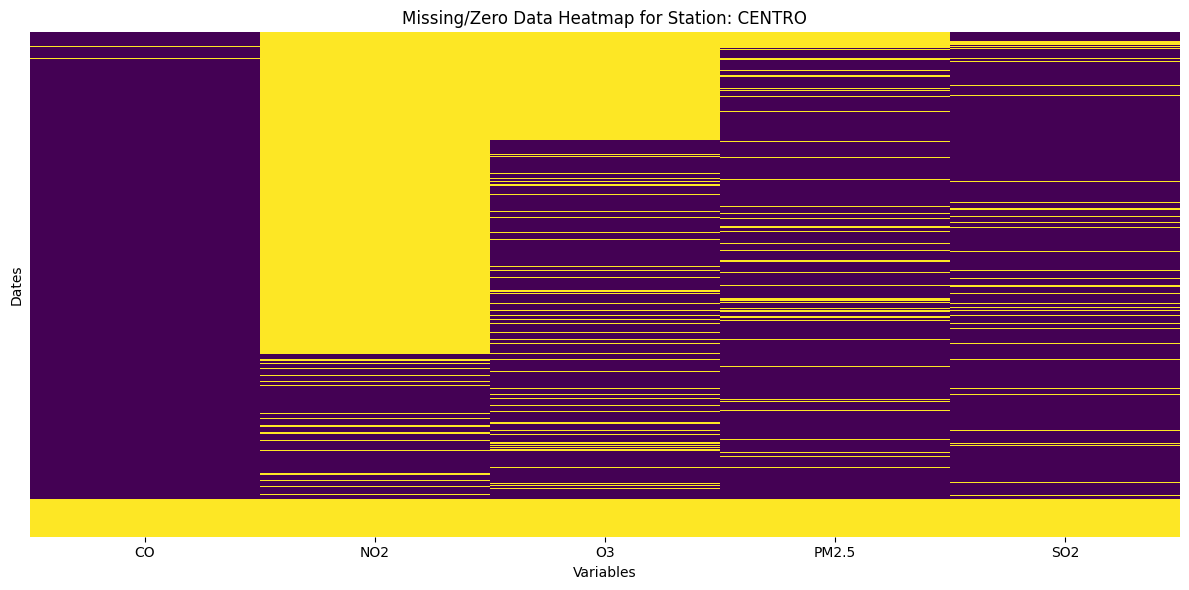

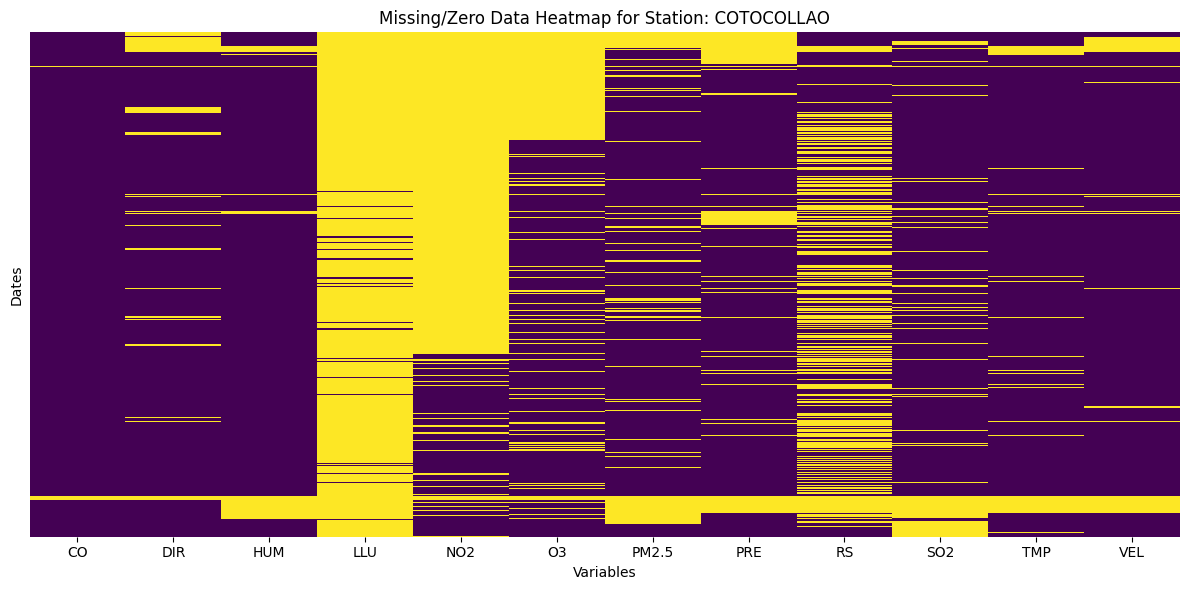

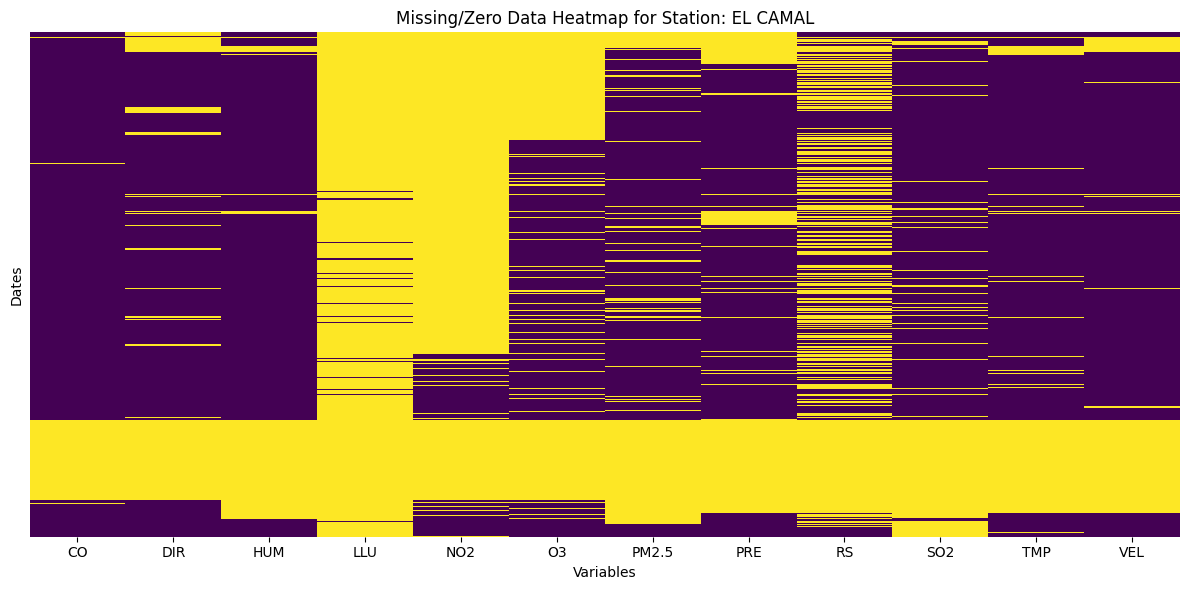

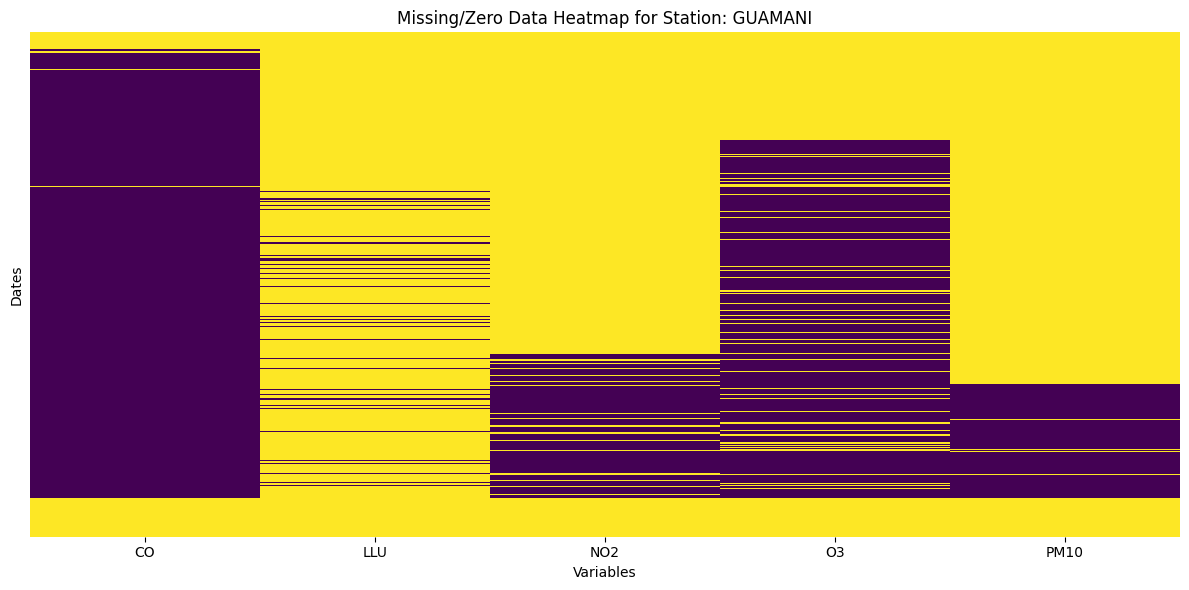

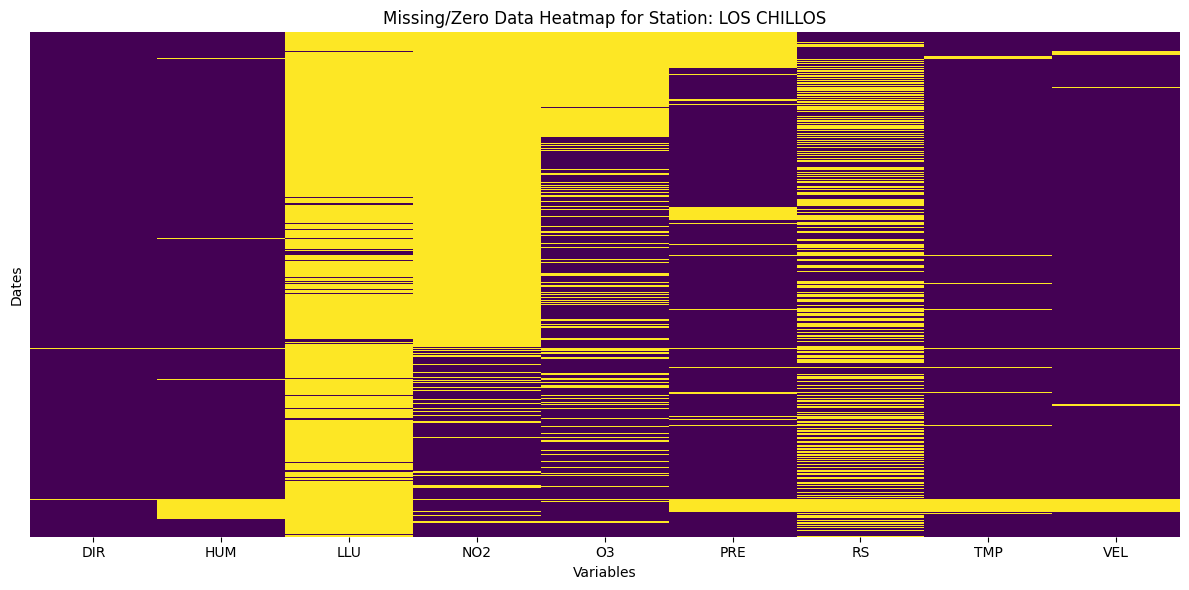

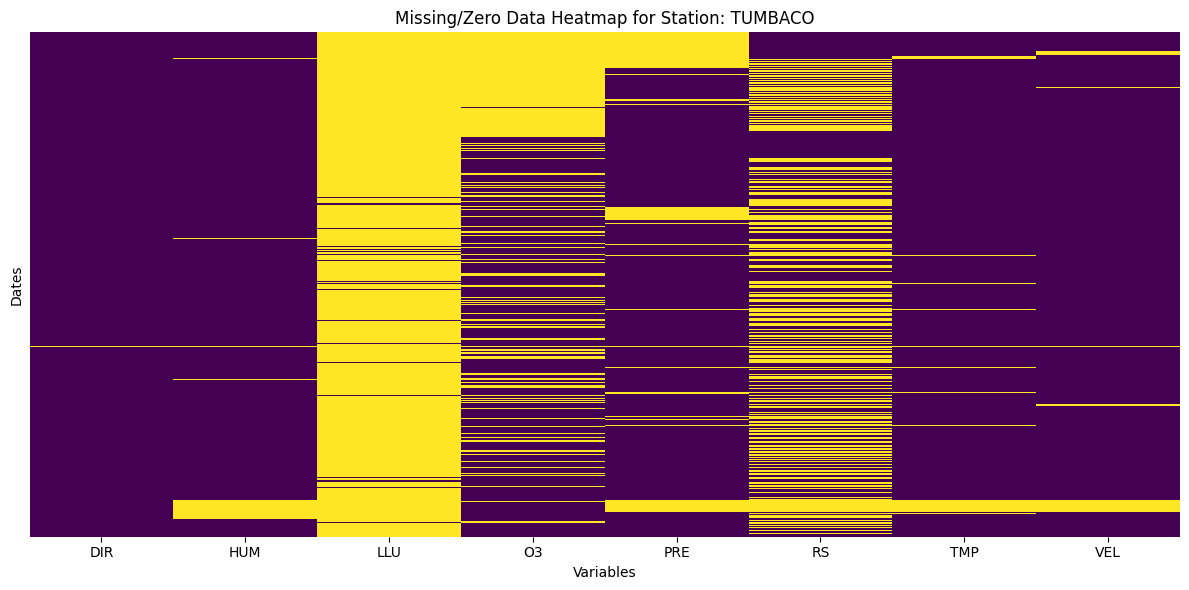

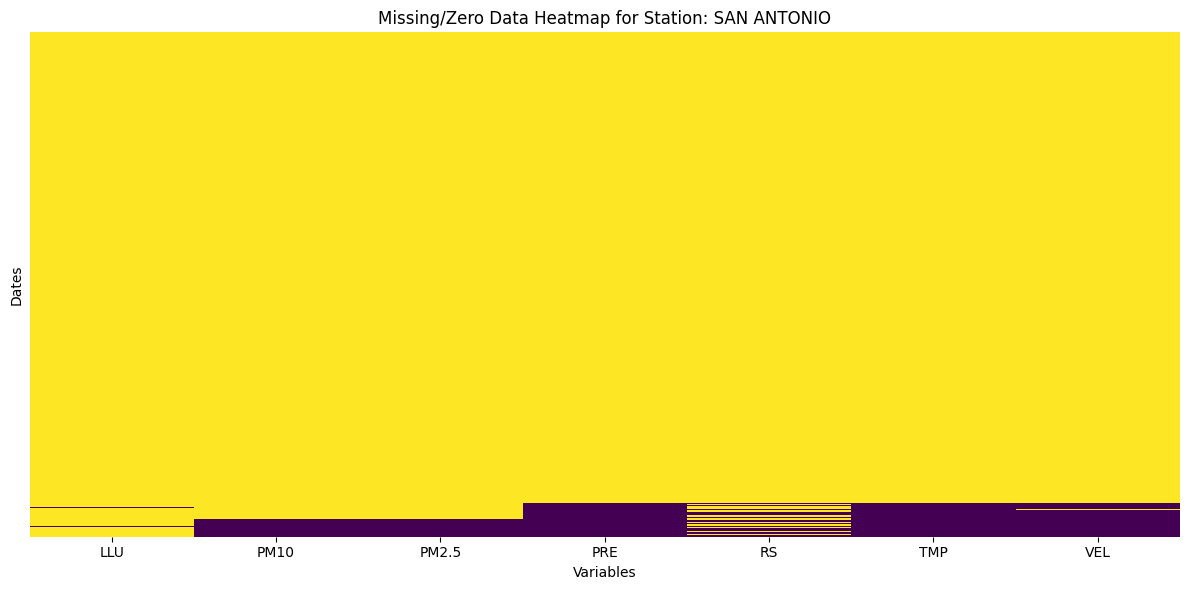

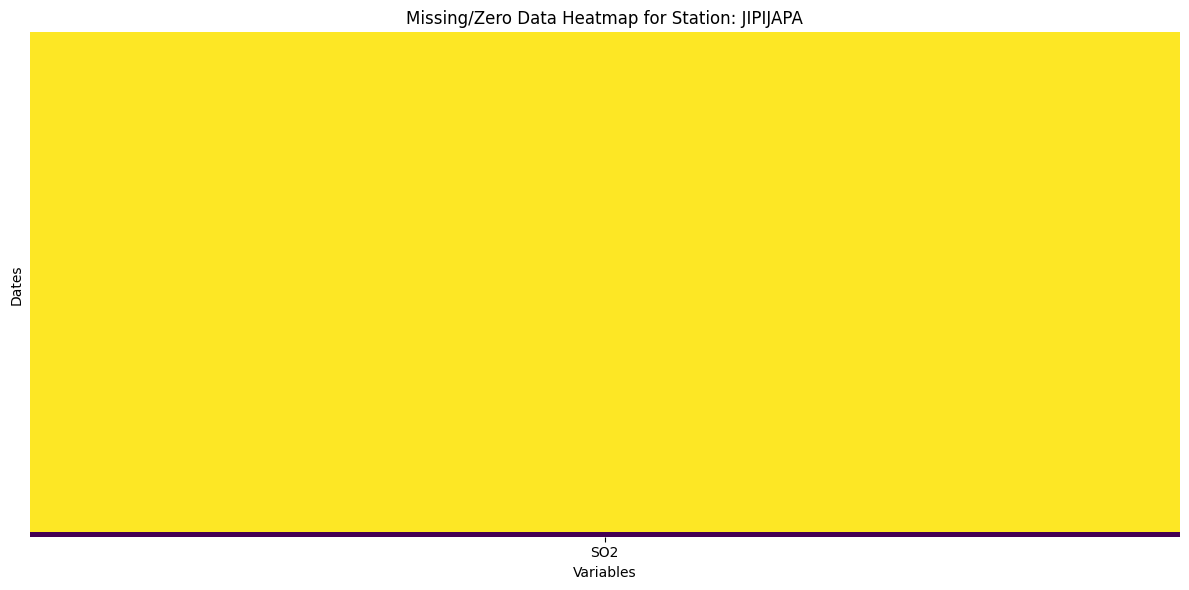

Saved DataFrames with actual values per station in station_dataframes dictionary.


In [20]:
# Define folder path
folder_path = "C:/Users/xavir/OneDrive/Escritorio/data_AI_202420/"
output_folder = os.path.join(folder_path, "station_outputs")
os.makedirs(output_folder, exist_ok=True)  # Ensure the output folder exists

# Load estaciones.csv to get the list of stations
estaciones_path = os.path.join(folder_path, "estaciones.csv")
try:
    estaciones_df = pd.read_csv(estaciones_path)
    estaciones = estaciones_df.iloc[:, 0].tolist()  # Assuming stations are in the first column
except Exception as e:
    print(f"Error loading estaciones.csv: {e}")
    estaciones = []

# Normalize station names (remove underscores and convert to uppercase)
def normalize_name(name):
    return name.replace("_", " ").upper()

estaciones = [normalize_name(st) for st in estaciones]

# List all CSV files in the folder (excluding estaciones.csv)
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".csv") and f != "estaciones.csv"]

# Load data
dataframes = {}
for path in file_paths:
    name = os.path.basename(path).replace(".csv", "")
    try:
        df = pd.read_csv(path)
        df.columns = [normalize_name(col) for col in df.columns]  # Normalize column names
        dataframes[name] = df
        print(f"{name} columns: {df.columns.tolist()}")  # Print column names to identify structure
    except Exception as e:
        print(f"Error loading {name}: {e}")

# Build values dictionary per station
station_dataframes = {}  # Dictionary to save DataFrames per station
for variable, df in dataframes.items():
    df = df.set_index(df.columns[0])
    df.index.name = "date"
    df = df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric to avoid dtype issues
    for station in estaciones:
        matched_station = difflib.get_close_matches(station, df.columns, n=1, cutoff=0.8)
        if matched_station:
            matched_station = matched_station[0]
            if station not in station_dataframes:
                station_dataframes[station] = pd.DataFrame(index=df.index)
            station_dataframes[station][variable] = df[matched_station]

# Save the individual DataFrames into CSV files
for station, station_df in station_dataframes.items():
    if not station_df.empty:
        # Save the DataFrame as a CSV file
        output_path = os.path.join(output_folder, f"{station}_data.csv")
        station_df.to_csv(output_path)
        print(f"Saved {station} data to {output_path}")

# Plot missing data heatmap per station
for station, station_df in station_dataframes.items():
    if not station_df.empty:
        # Compute missing/zero value flags for visualization
        missing_data = (station_df == 0) | station_df.isnull()

        plt.figure(figsize=(12, 6))
        sns.heatmap(missing_data.astype(float), cbar=False, cmap='viridis', yticklabels=False)
        plt.title(f"Missing/Zero Data Heatmap for Station: {station}")
        plt.xlabel("Variables")
        plt.ylabel("Dates")
        plt.tight_layout()
        plt.show()

# station_dataframes now contains DataFrames with actual values
print("Saved DataFrames with actual values per station in station_dataframes dictionary.")


#### 2.1.1 Eliminación de Valores Faltantes

Los datos faltantes pueden afectar negativamente los resultados del análisis y la precisión de los modelos. Existen diferentes enfoques para manejar estos datos:

Eliminación directa: Se eliminan registros o columnas con un porcentaje elevado de datos faltantes.

Interpolación: Se rellenan los valores faltantes mediante métodos de aproximación, como la interpolación lineal o basada en el tiempo.

Transformación de valores: Los valores cero a menudo se consideran datos faltantes en contextos específicos y se transforman para ser tratados en el análisis.

In [21]:
# Define thresholds
missing_threshold = 70  # % of missing data allowed before dropping column
zero_threshold = 70  # % of zero values allowed before dropping column

# Define selected stations
selected_stations = ["EL CAMAL", "COTOCOLLAO", "CENTRO", "CARAPUNGO", "BELISARIO"]

filtered_station_dataframes = {}

for station, df in station_dataframes.items():
    if station not in selected_stations:
        continue  # Skip stations not in the selected list

    print(f"🔍 Processing {station} - Dropping 2004 Data & Reapplying Filtering")

    # Convert index to datetime (if not already)
    df.index = pd.to_datetime(df.index, format="mixed", dayfirst=True, errors="raise")

    # Drop all data from 2004
    df = df[df.index.year != 2004]
    print(f"🚫 {station} - Dropped Data from 2004")

    # Drop all data from June 2017 onwards
    df = df[df.index < "2017-06-01"]

    # Ensure all columns except 'date' are numeric
    df = df.infer_objects(copy=False)  # Convert object dtypes to more specific types
    df = df.apply(pd.to_numeric, errors='coerce')  # Ensure all columns are numeric

    # Convert zero values to NaN to allow interpolation to fill them
    df.replace(0, np.nan, inplace=True)

    # Drop columns with >70% missing values
    missing_percents = (df.isna().sum() / len(df)) * 100
    cols_to_drop = missing_percents[missing_percents > missing_threshold].index.tolist()
    df.drop(columns=cols_to_drop, inplace=True)
    print(f"🚫 {station} - Dropped Columns (After Filtering): {cols_to_drop}")

    # Apply advanced interpolation methods
    df.interpolate(method="linear", inplace=True)  # First pass: Linear interpolation
    df.interpolate(method="time", inplace=True)  # Second pass: Time-based interpolation
    df.bfill(inplace=True)  # Backfill to ensure no remaining missing values
    df.ffill(inplace=True)  # Forward fill for final cleanup

    # imputer = KNNImputer(n_neighbors=5)
    # df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    # Drop rows where >80% of values are still missing
    row_missing_percents = (df.isna().sum(axis=1) / df.shape[1]) * 100
    df = df[row_missing_percents <= 80]

    print(f"✅ {station} - Final Cleaned Shape: {df.shape}")

    filtered_station_dataframes[station] = df 

    print(f"✅ {station} - 2004 Removal & Final Filtering Complete")

🔍 Processing BELISARIO - Dropping 2004 Data & Reapplying Filtering
🚫 BELISARIO - Dropped Data from 2004
🚫 BELISARIO - Dropped Columns (After Filtering): ['LLU']
✅ BELISARIO - Final Cleaned Shape: (91889, 11)
✅ BELISARIO - 2004 Removal & Final Filtering Complete
🔍 Processing CARAPUNGO - Dropping 2004 Data & Reapplying Filtering
🚫 CARAPUNGO - Dropped Data from 2004
🚫 CARAPUNGO - Dropped Columns (After Filtering): ['LLU', 'NO2', 'PM10']
✅ CARAPUNGO - Final Cleaned Shape: (91889, 10)
✅ CARAPUNGO - 2004 Removal & Final Filtering Complete
🔍 Processing CENTRO - Dropping 2004 Data & Reapplying Filtering
🚫 CENTRO - Dropped Data from 2004
🚫 CENTRO - Dropped Columns (After Filtering): ['NO2']
✅ CENTRO - Final Cleaned Shape: (91889, 4)
✅ CENTRO - 2004 Removal & Final Filtering Complete
🔍 Processing COTOCOLLAO - Dropping 2004 Data & Reapplying Filtering
🚫 COTOCOLLAO - Dropped Data from 2004
🚫 COTOCOLLAO - Dropped Columns (After Filtering): ['LLU', 'NO2']
✅ COTOCOLLAO - Final Cleaned Shape: (91889, 

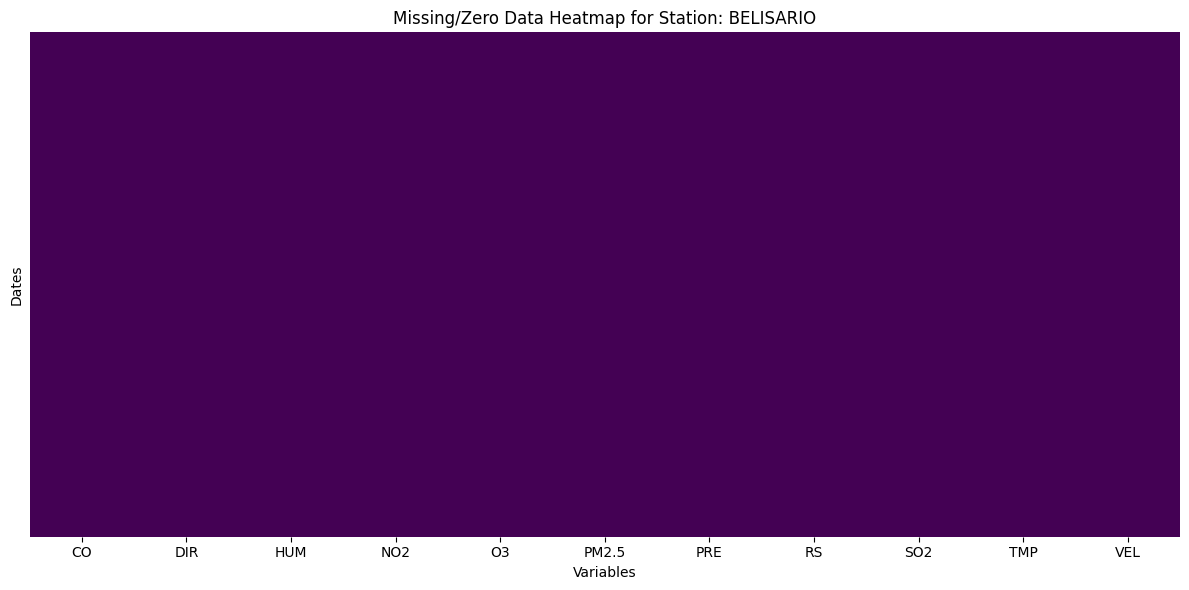

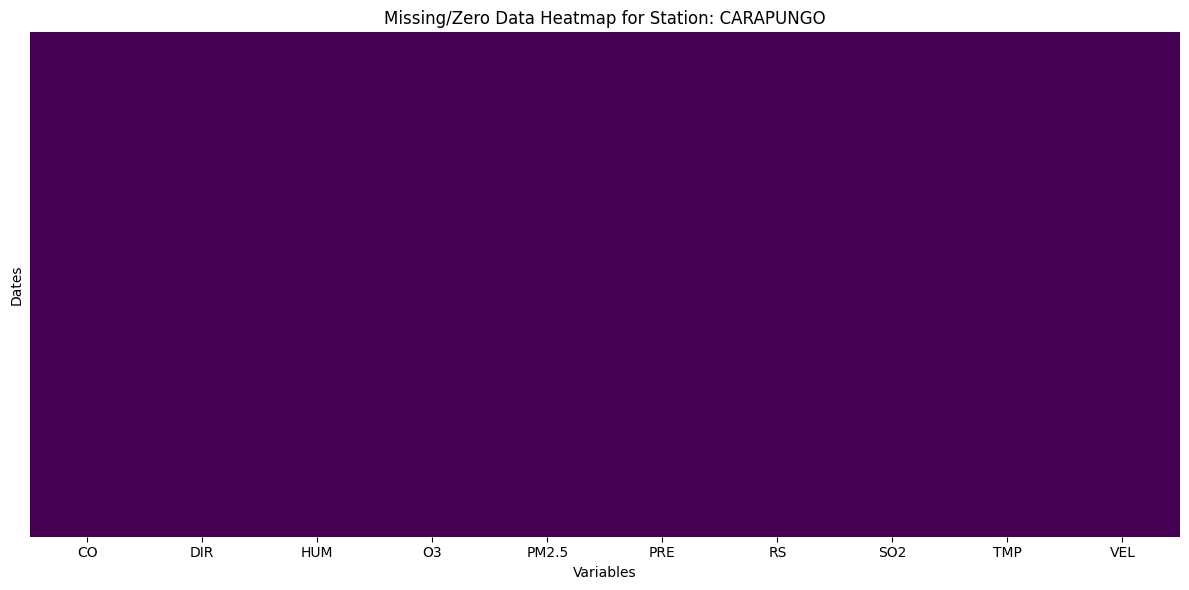

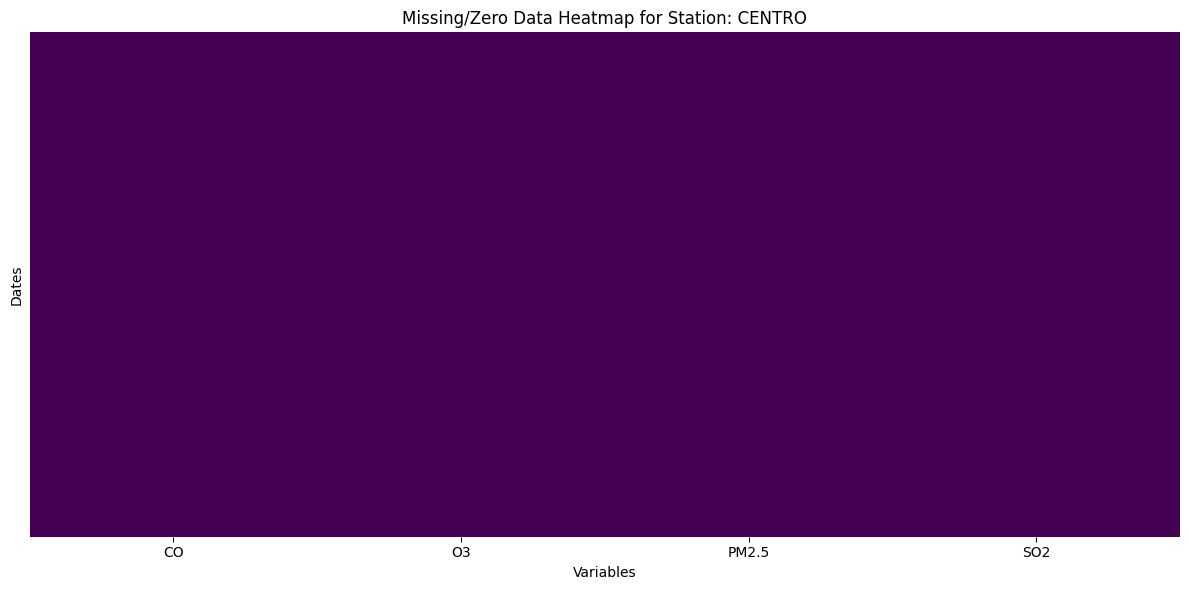

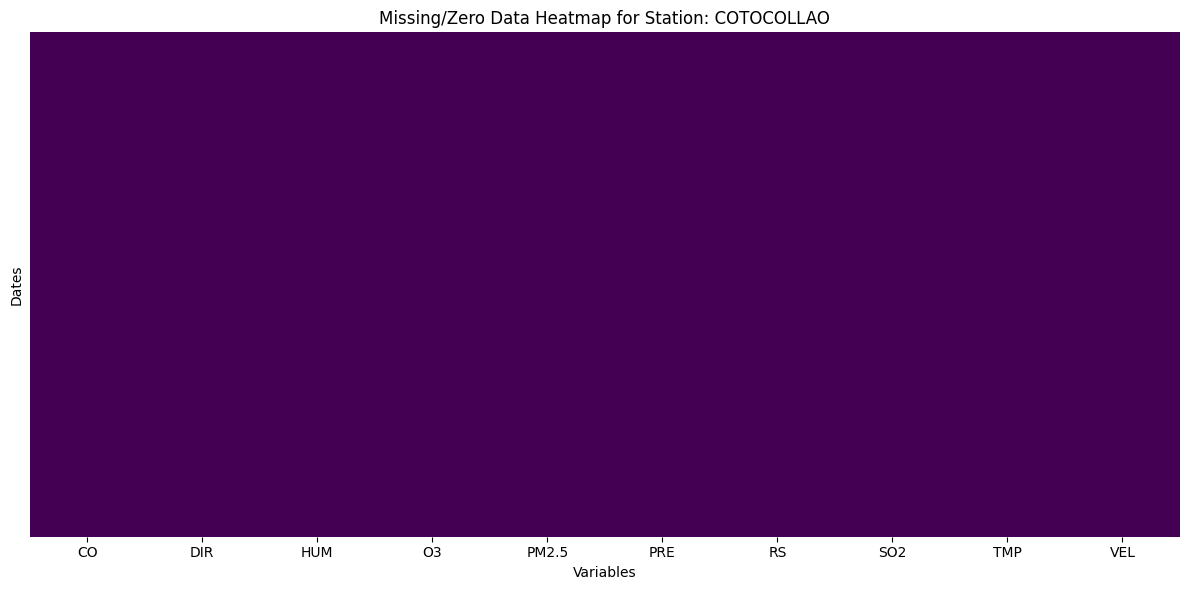

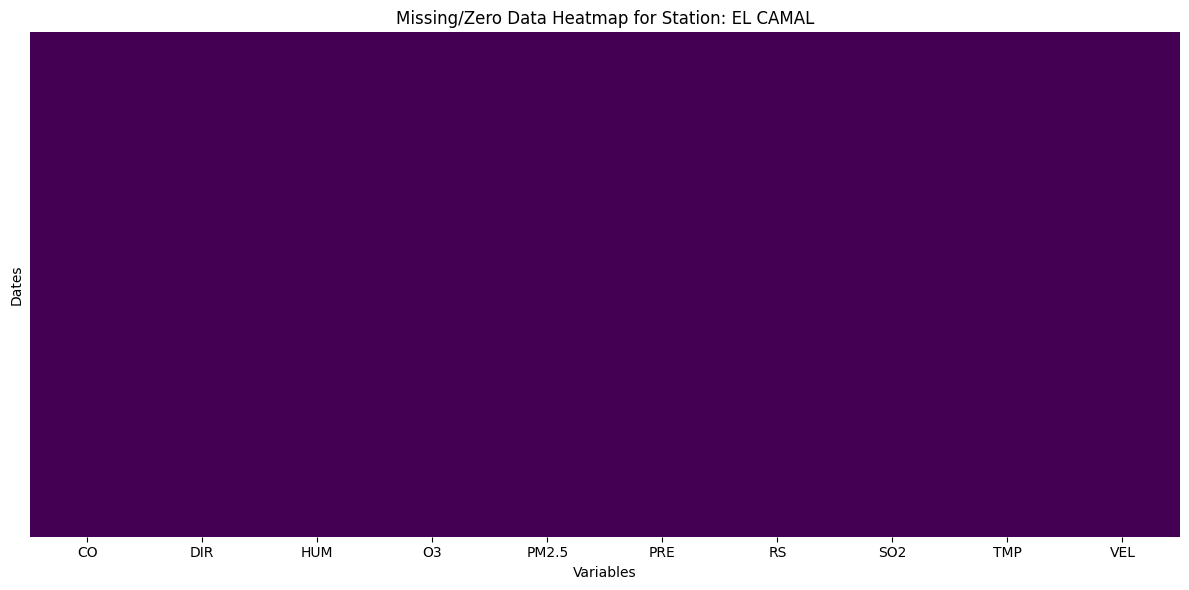

In [22]:
# Plot missing data heatmap per station
for station, station_df in filtered_station_dataframes.items():
    if not station_df.empty:
        # Compute missing/zero value flags for visualization
        missing_data = (station_df == 0) | station_df.isnull()

        plt.figure(figsize=(12, 6))
        sns.heatmap(missing_data.astype(float), cbar=False, cmap='viridis', yticklabels=False)
        plt.title(f"Missing/Zero Data Heatmap for Station: {station}")
        plt.xlabel("Variables")
        plt.ylabel("Dates")
        plt.tight_layout()
        plt.show()

#### 2.1.2 Normalización de Datos

La normalización permite homogeneizar los nombres de estaciones y variables, eliminando inconsistencias en la nomenclatura. Esto mejora la integración de diferentes fuentes de datos y facilita su manipulación en etapas posteriores.

In [23]:
# Define selected stations
selected_stations = ["EL CAMAL", "COTOCOLLAO", "CENTRO", "CARAPUNGO", "BELISARIO"]

# Initialize an empty list to store individual station DataFrames
merged_data = []

# Iterate through the filtered station DataFrames and add a station identifier
for station, df in filtered_station_dataframes.items():
    if station not in selected_stations:
        continue  # Skip stations not in the selected list
    
    df = df.copy()
    df["Station"] = station  # Add a column to indicate the station
    
    # Append the DataFrame to the list
    merged_data.append(df)

# Concatenate all station DataFrames into a single DataFrame
final_merged_df = pd.concat(merged_data, ignore_index=False)

# Ensure the index is datetime for proper time-series analysis
final_merged_df.index = pd.to_datetime(final_merged_df.index)

# Reset the index for easier analysis
final_merged_df.reset_index(inplace=True)

print(f"✅ Merged Data Saved at: {output_path}")
print(f"📊 Final Merged Data Shape: {final_merged_df.shape}")

# Display first few rows
display(final_merged_df.head())


✅ Merged Data Saved at: C:/Users/xavir/OneDrive/Escritorio/data_AI_202420/station_outputs\JIPIJAPA_data.csv
📊 Final Merged Data Shape: (459445, 13)


date    CO    DIR     HUM    NO2     O3  PM2.5    PRE    RS  \
0 2005-01-01 00:00:00  2.75  58.38   99.88  14.98  43.01  38.47  724.5  5.44   
1 2005-01-01 01:00:00  2.62  58.38  100.00  14.98  43.01  38.47  724.5  5.44   
2 2005-01-01 02:00:00  3.29  58.38   99.92  14.98  43.01  38.47  724.5  5.44   
3 2005-01-01 03:00:00  3.37  58.38   97.19  14.98  43.01  38.47  724.5  5.44   
4 2005-01-01 04:00:00  2.70  58.38   94.59  14.98  43.01  38.47  724.5  5.44   

     SO2   TMP   VEL    Station  
0  35.58  9.02  1.78  BELISARIO  
1  24.37  8.20  1.78  BELISARIO  
2  27.25  8.23  1.78  BELISARIO  
3  26.42  8.04  1.78  BELISARIO  
4  22.35  6.97  1.78  BELISARIO

#### 2.2 Series Temporales y Estacionariedad

Una serie temporal es una secuencia de datos ordenados cronológicamente. El análisis de series temporales busca identificar patrones como tendencias, estacionalidades y ciclos.

#### 2.2.1 Estacionariedad

Un requisito común en muchos modelos de series temporales es que los datos sean estacionarios, es decir, que sus propiedades estadísticas (media, varianza) no cambien a lo largo del tiempo.

Prueba de Dickey-Fuller (ADF): Este test se utiliza para evaluar si una serie temporal es estacionaria. Un valor p superior a 0,05 indica que la serie no es estacionaria.

Transformaciones para la estacionariedad: Cuando una serie no es estacionaria, se pueden aplicar diferencias (“differencing”) o transformaciones logarítmicas para estabilizar la varianza y eliminar tendencias.

#### 2.2.2 Componentes de una Serie Temporal

Tendencia: Representa el cambio a largo plazo en los datos.

Estacionalidad: Fluctuaciones que se repiten en intervalos regulares, como patrones anuales o mensuales.

Ciclo: Variaciones que ocurren en periodos no regulares, influenciados por factores económicos o sociales.

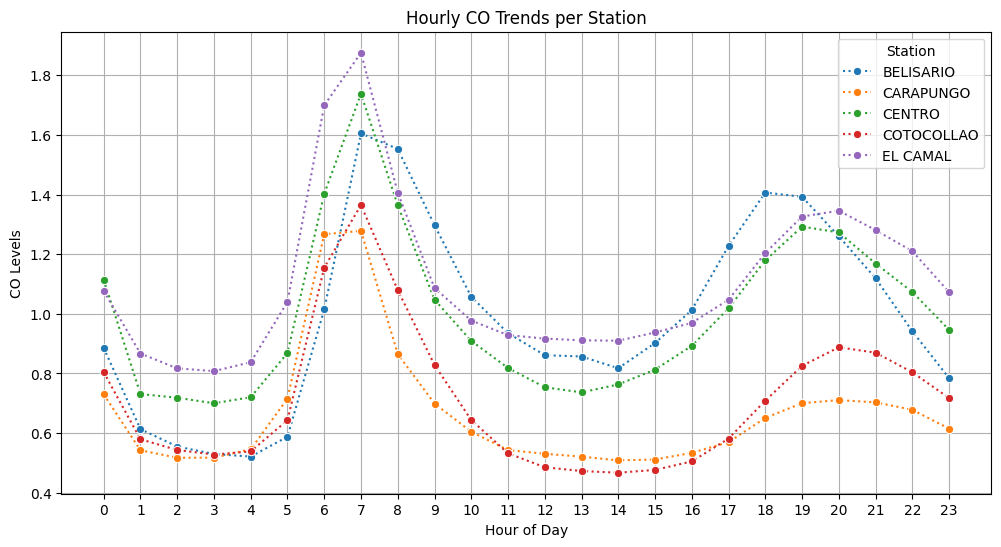

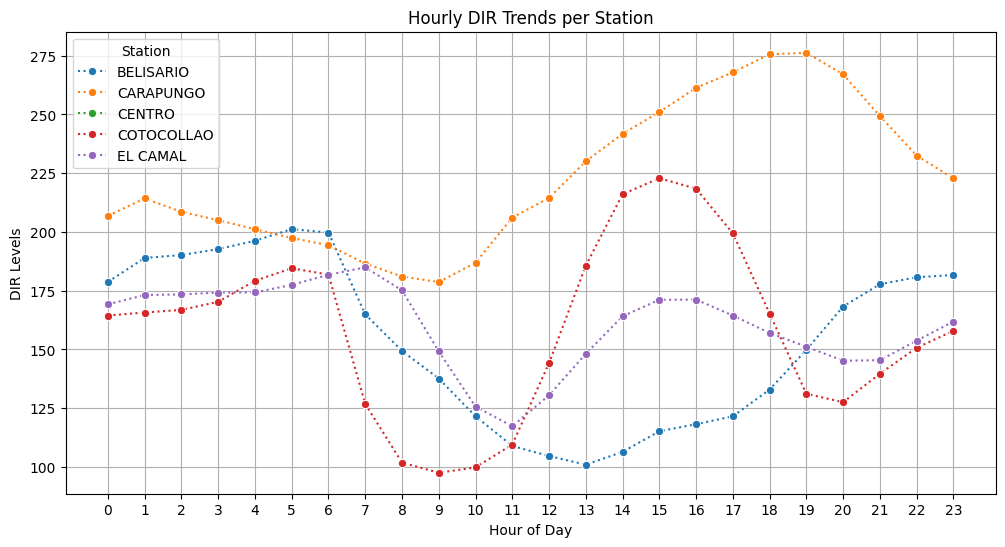

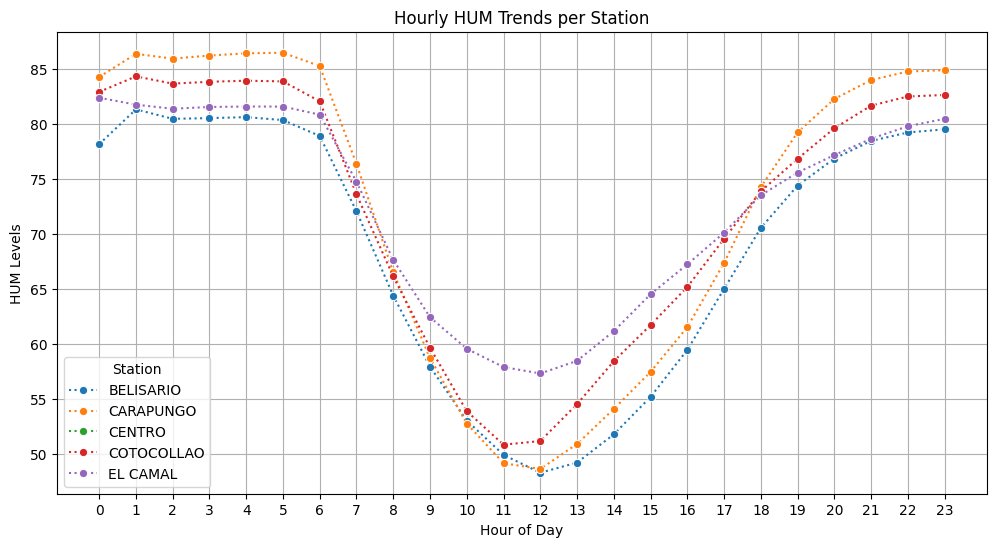

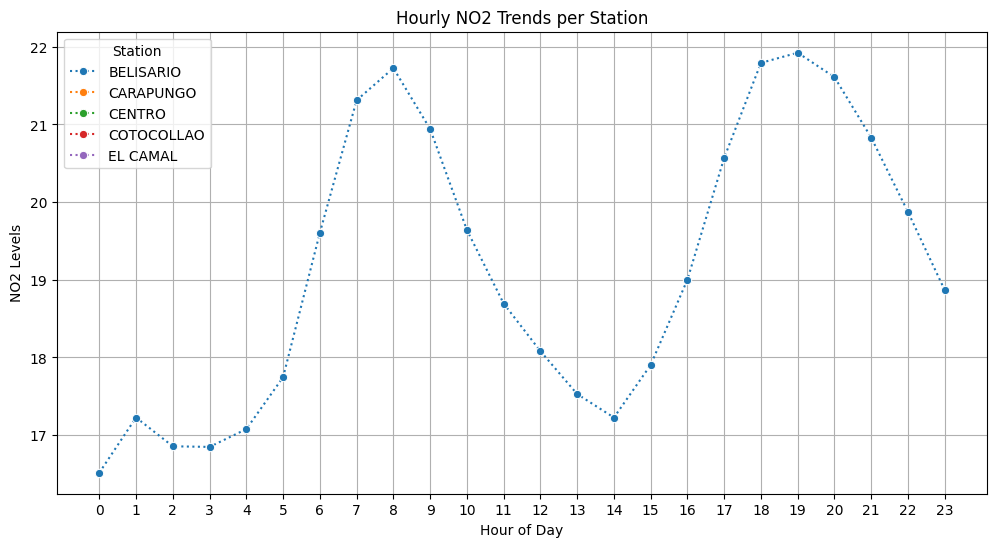

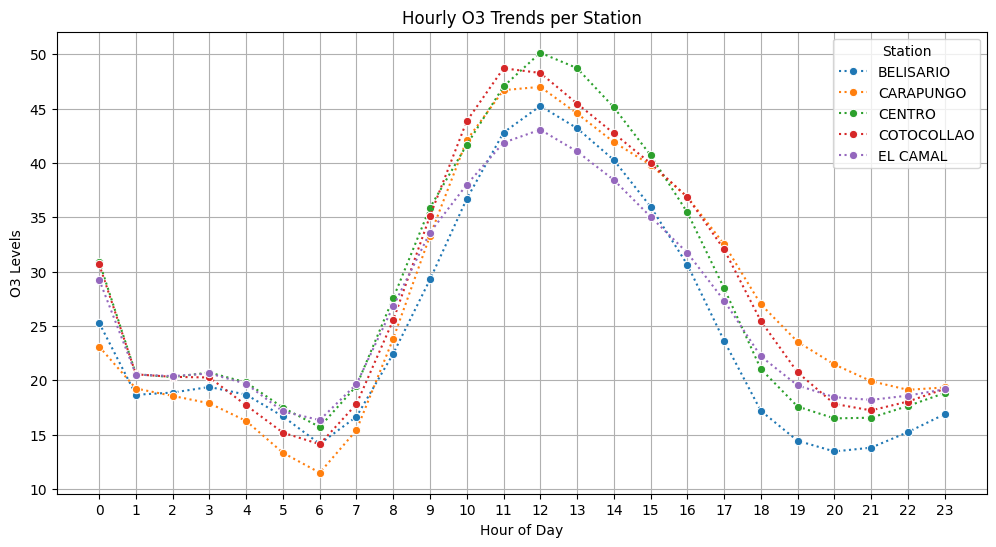

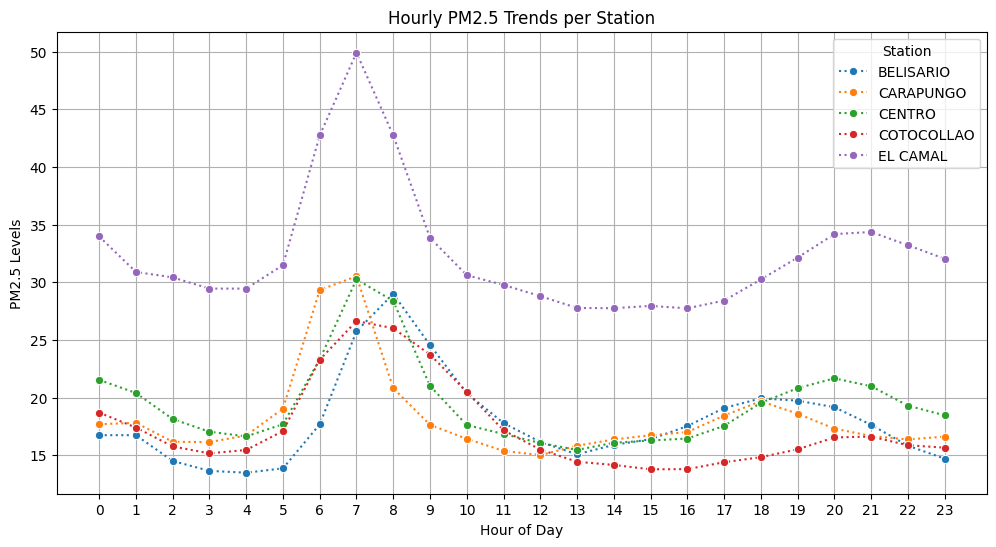

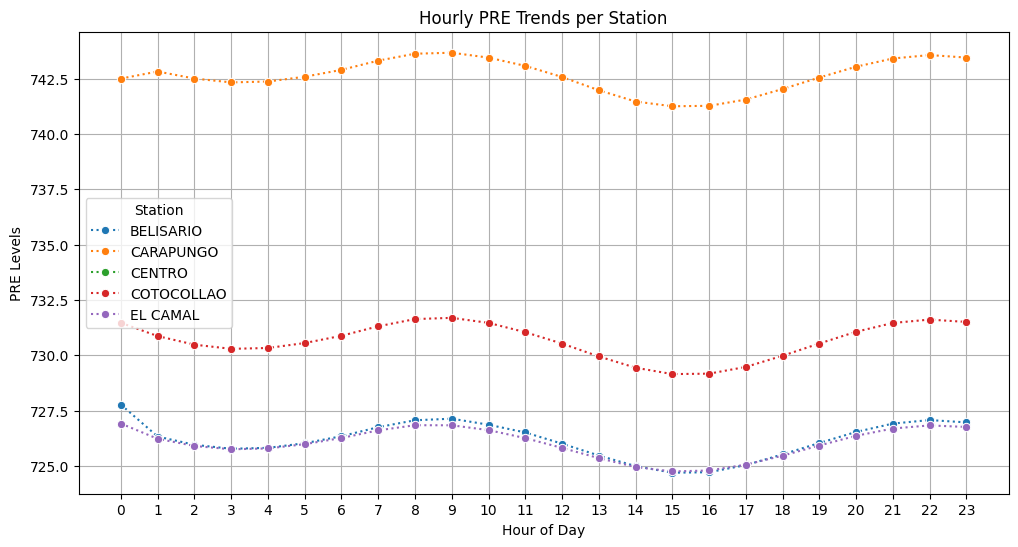

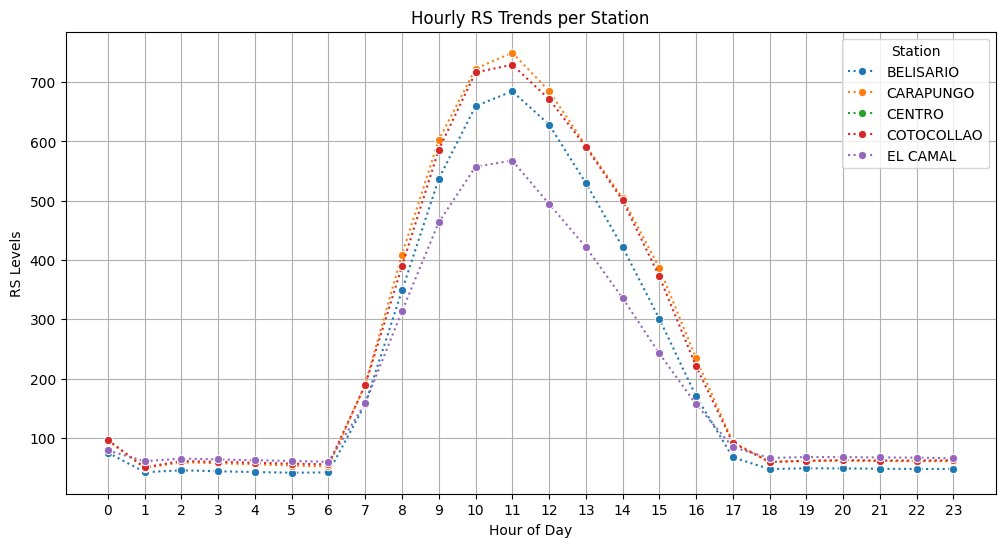

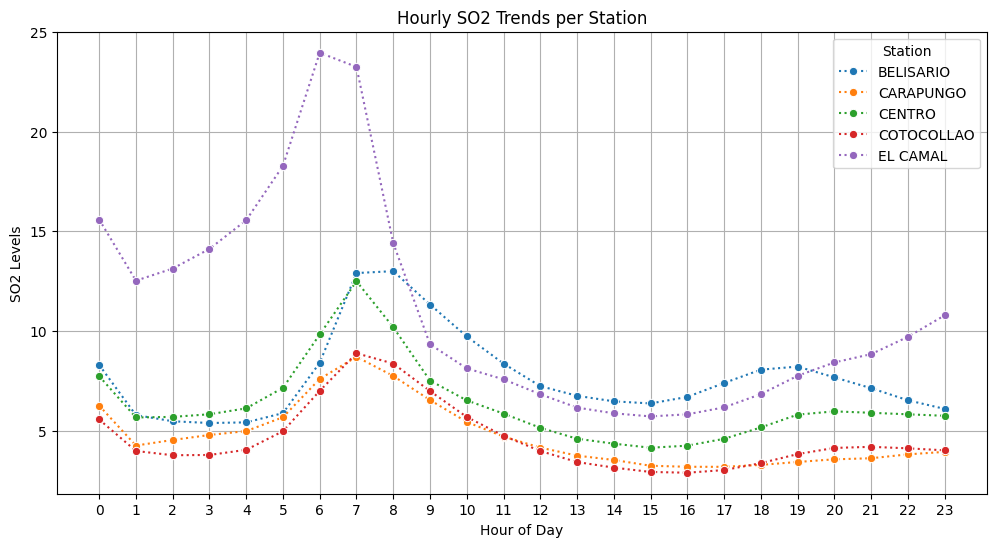

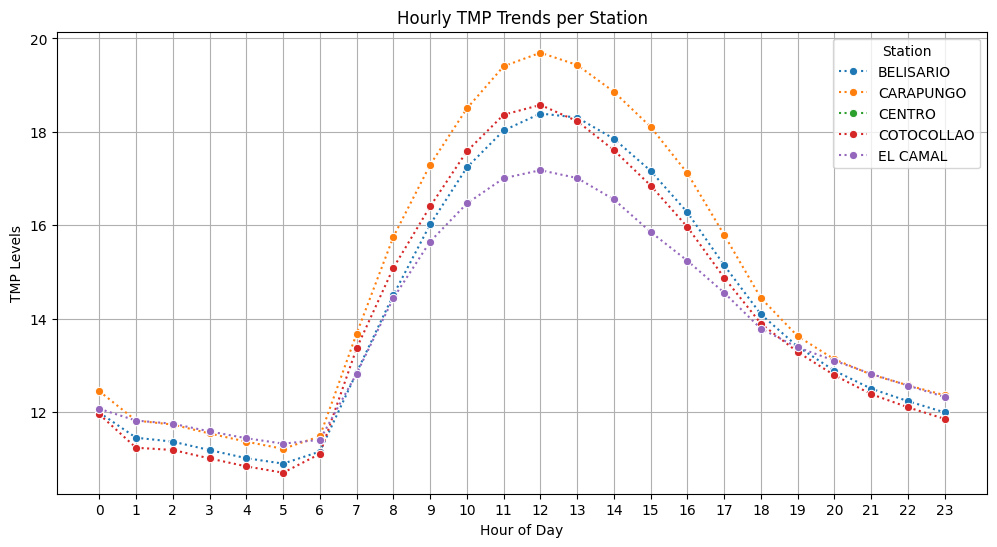

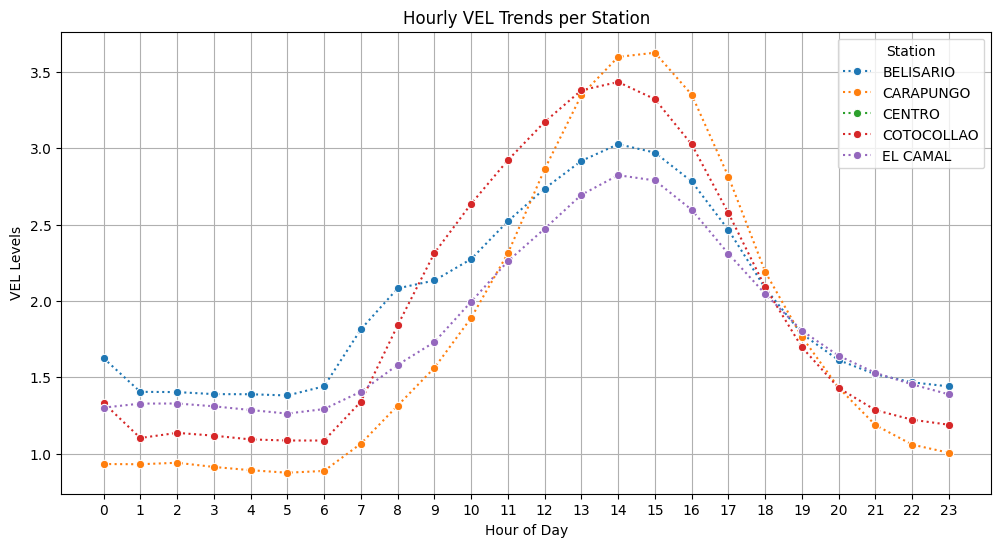

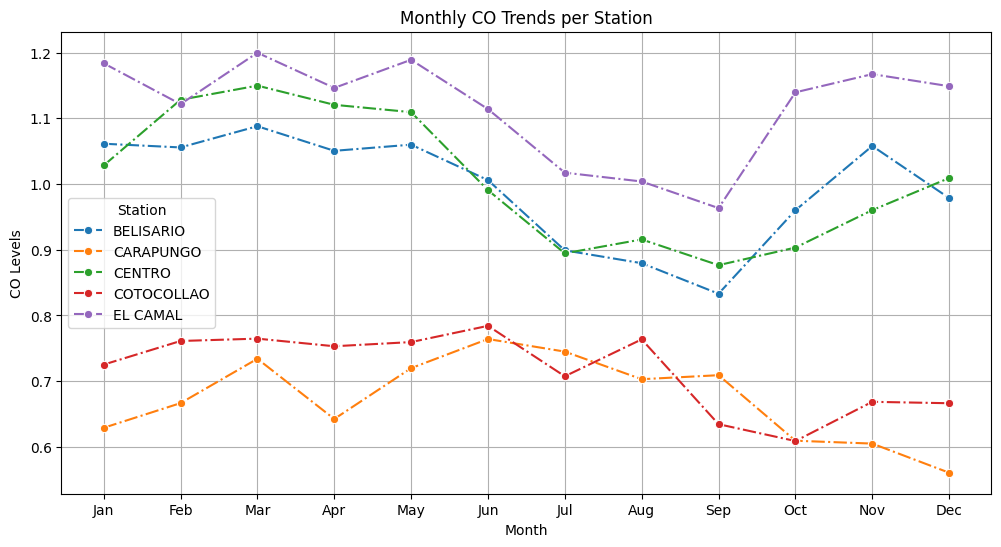

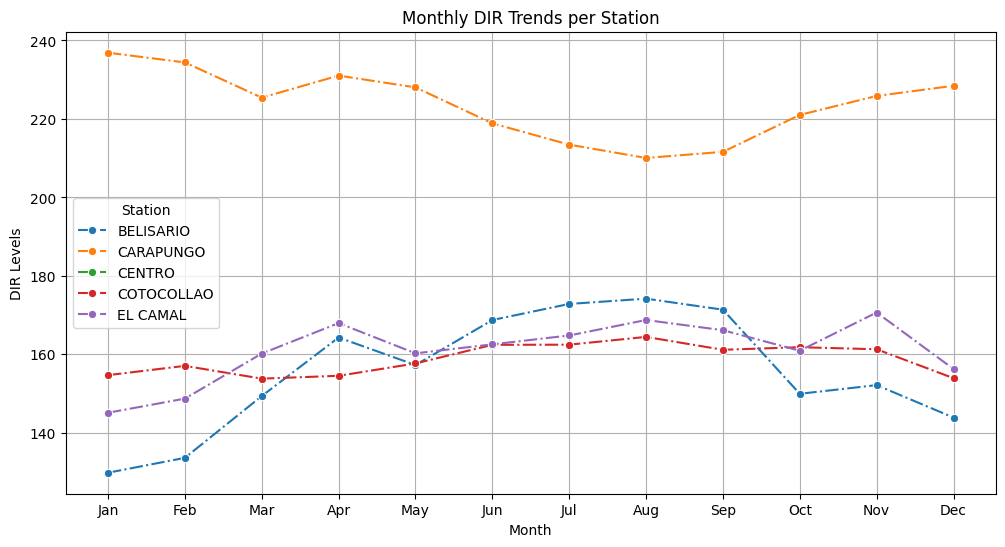

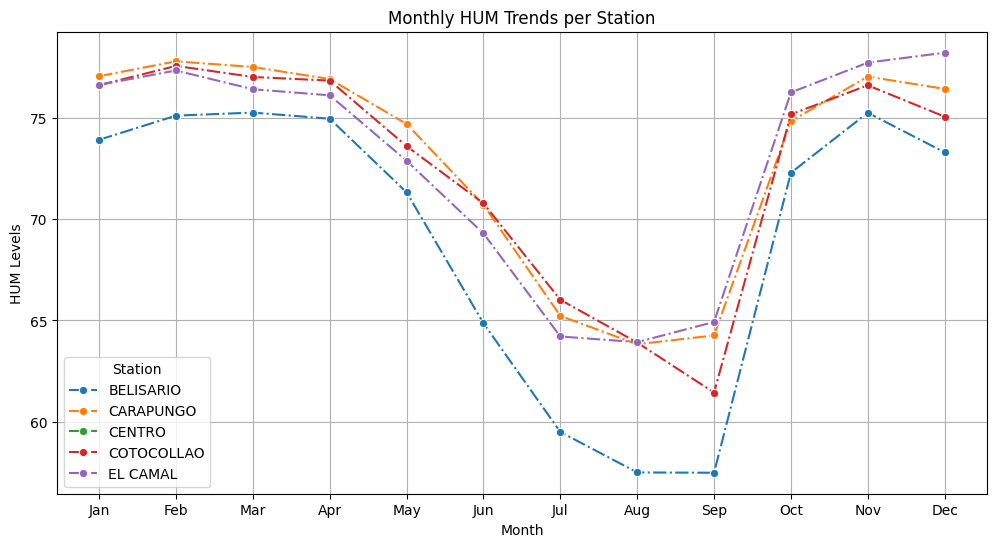

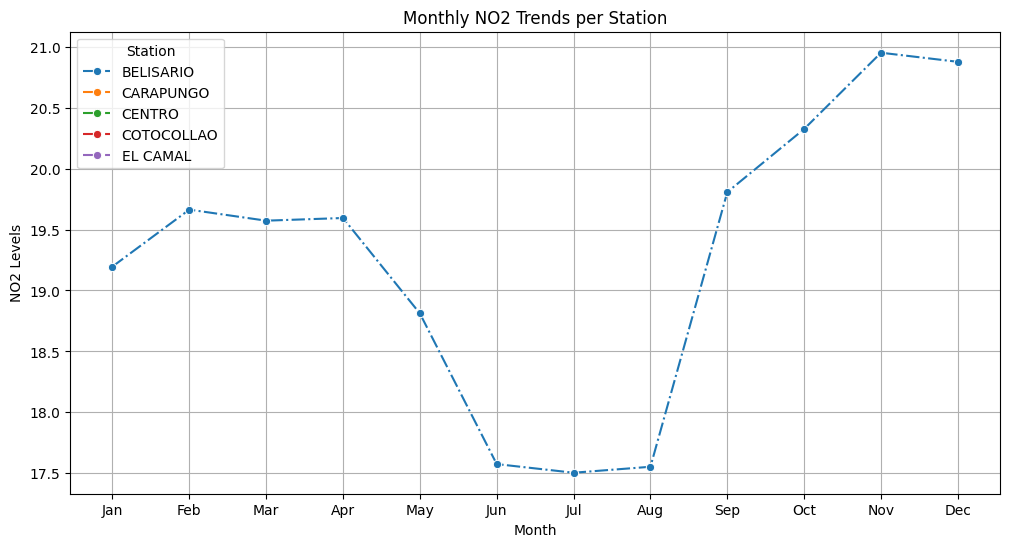

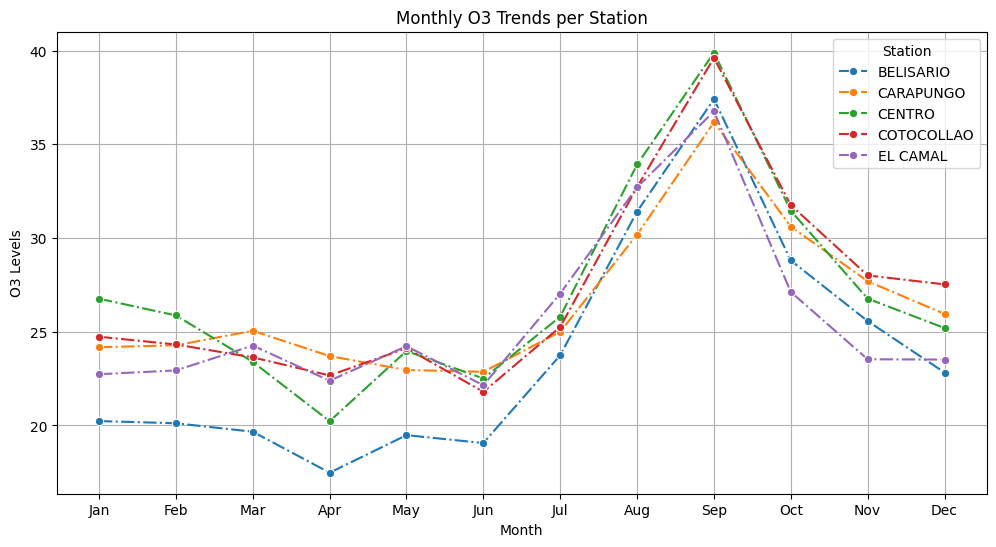

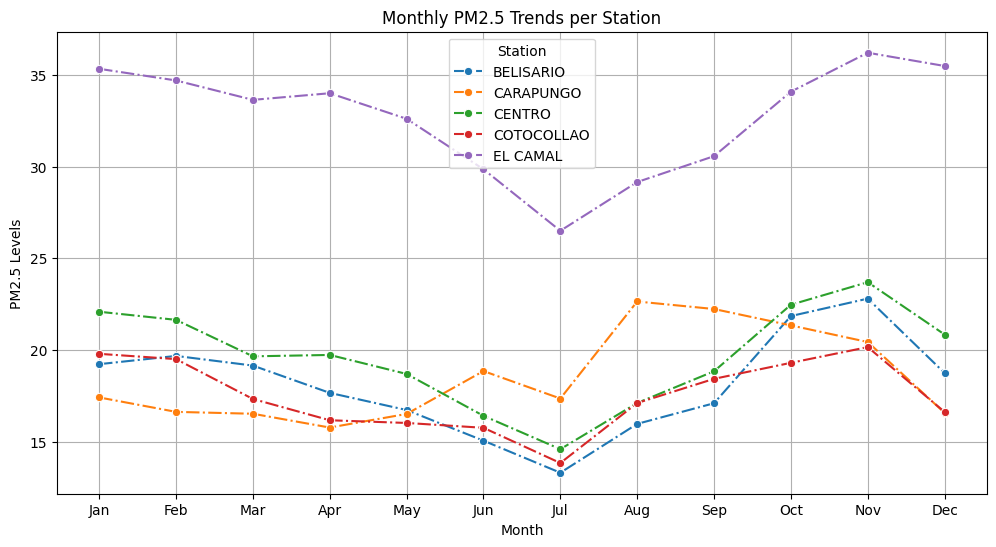

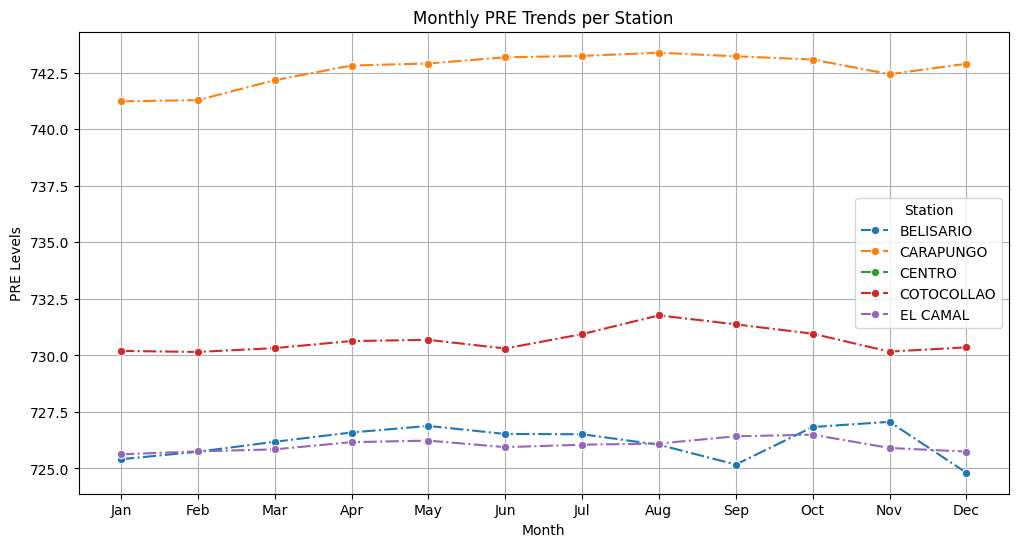

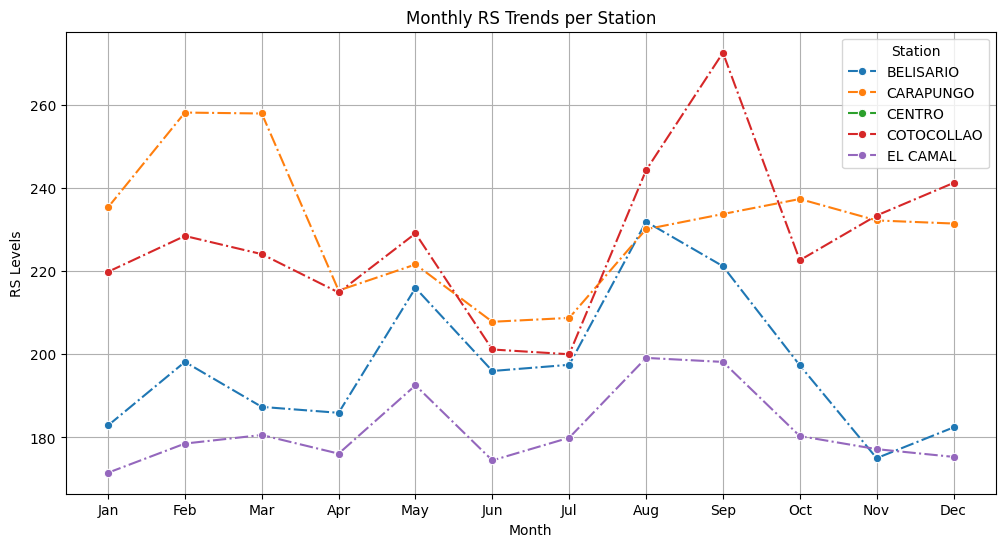

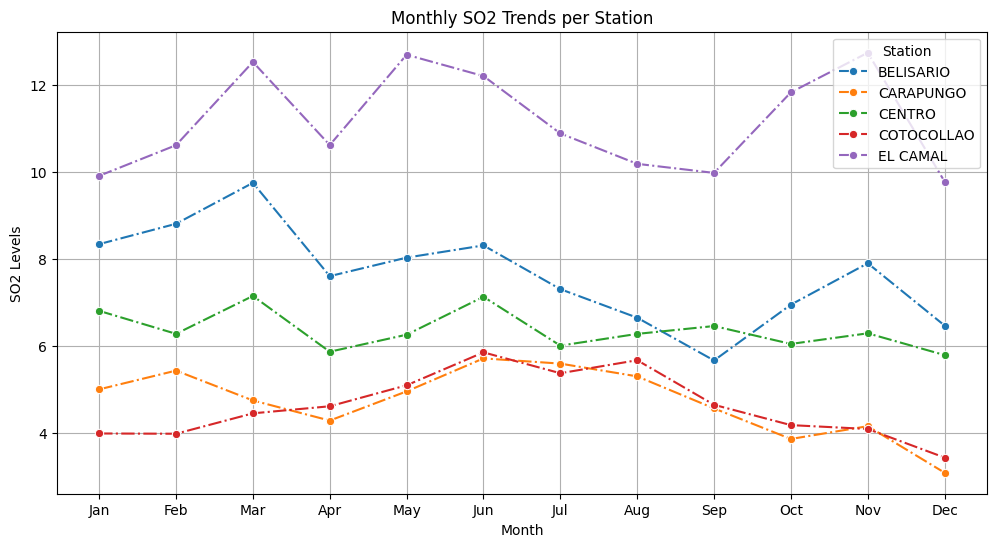

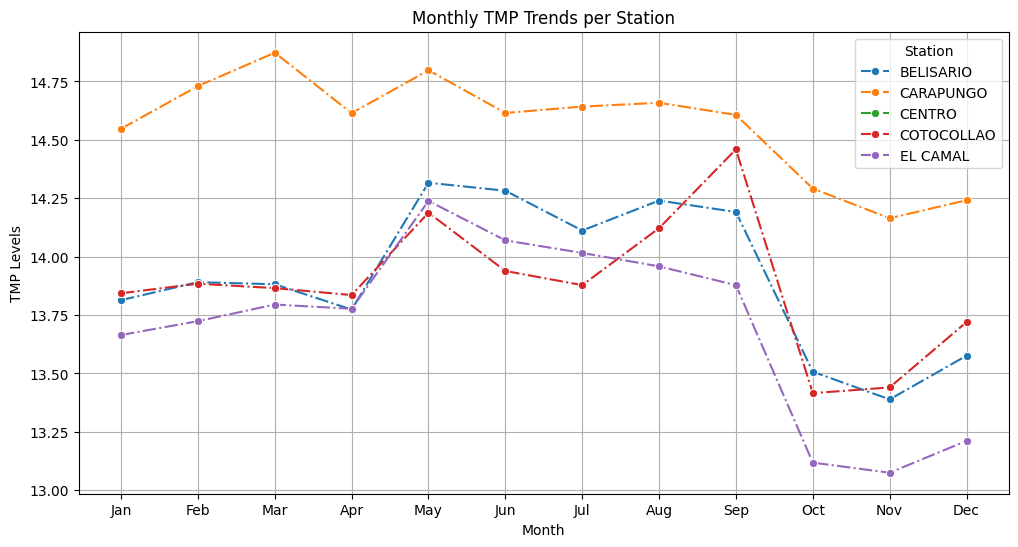

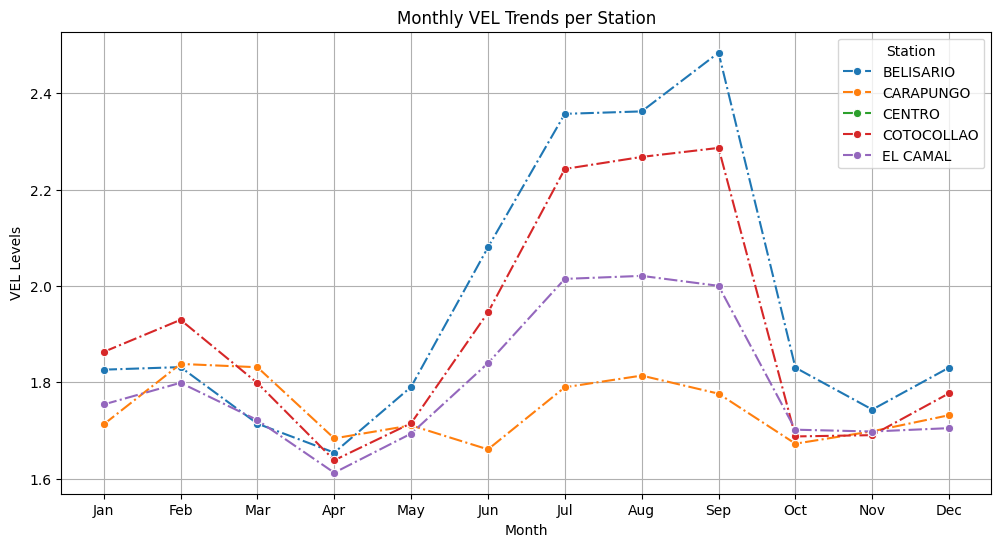

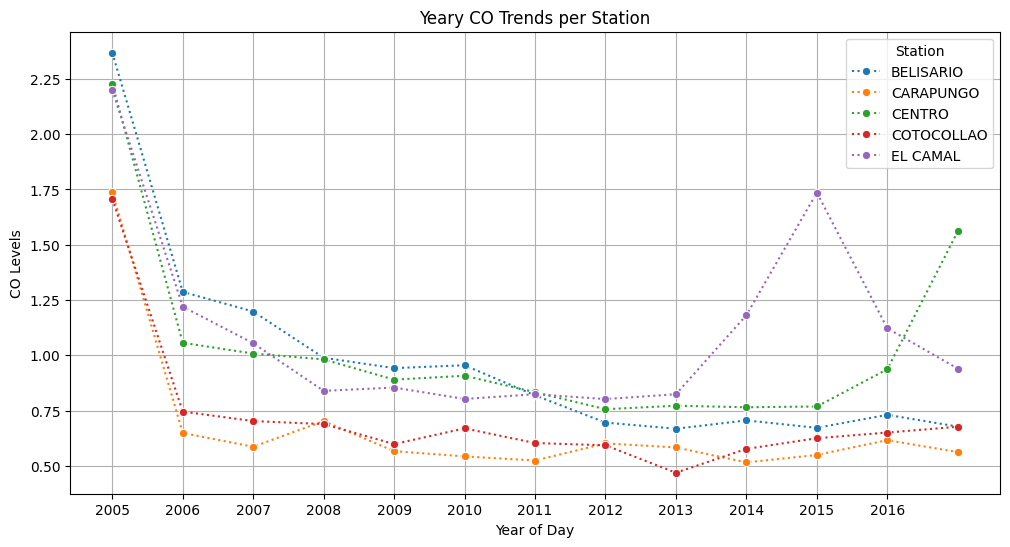

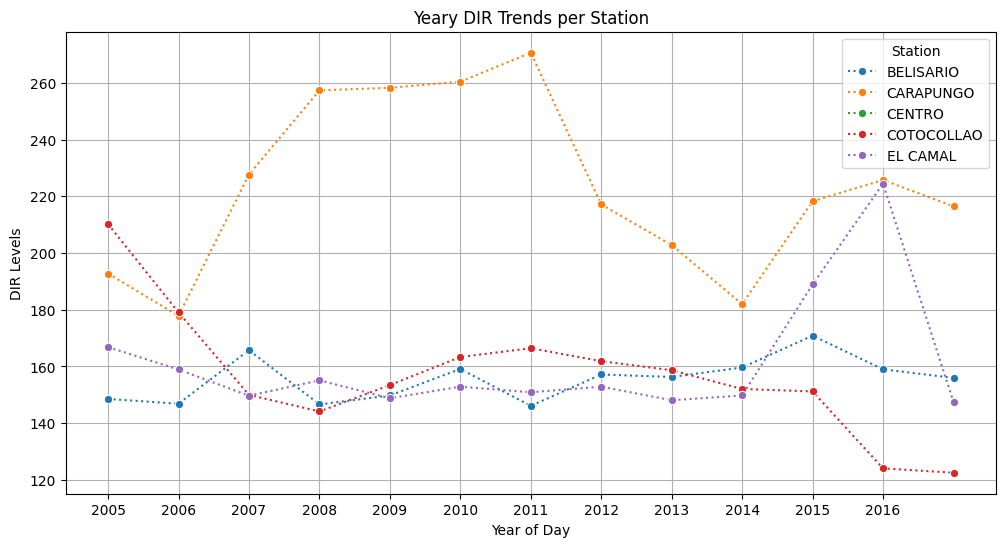

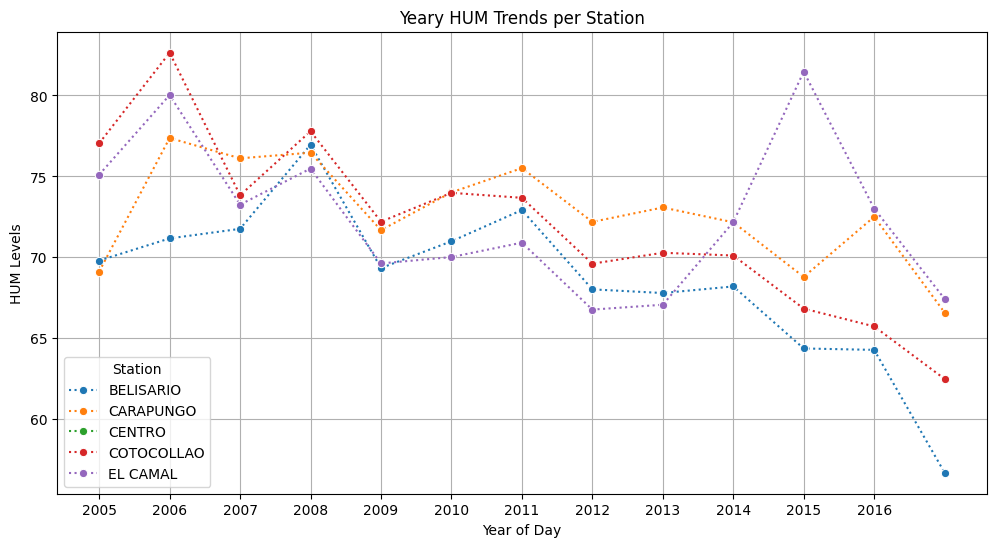

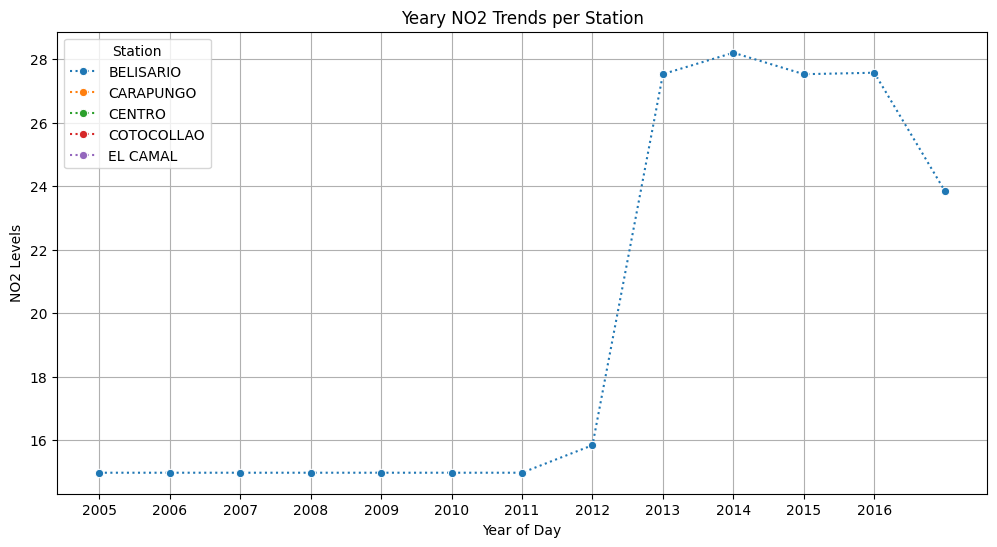

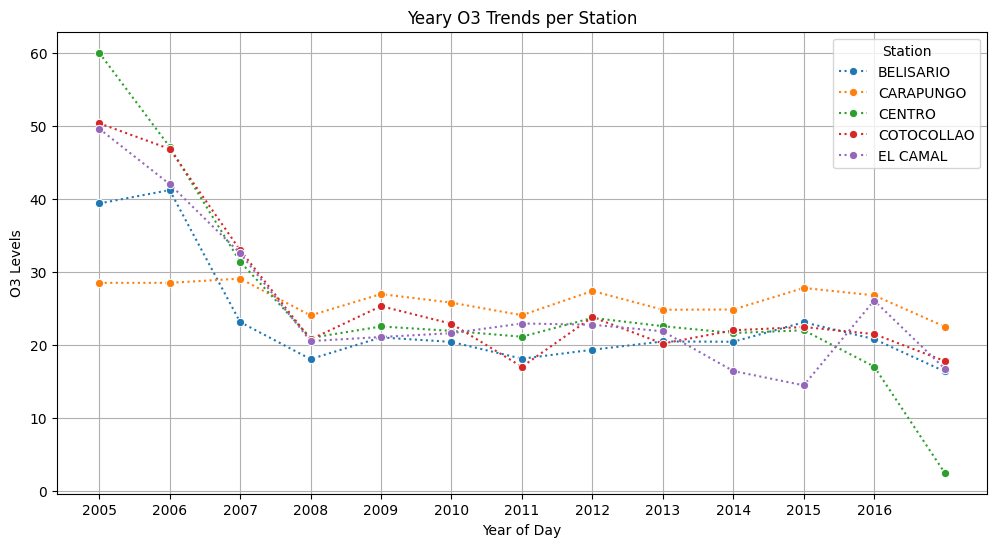

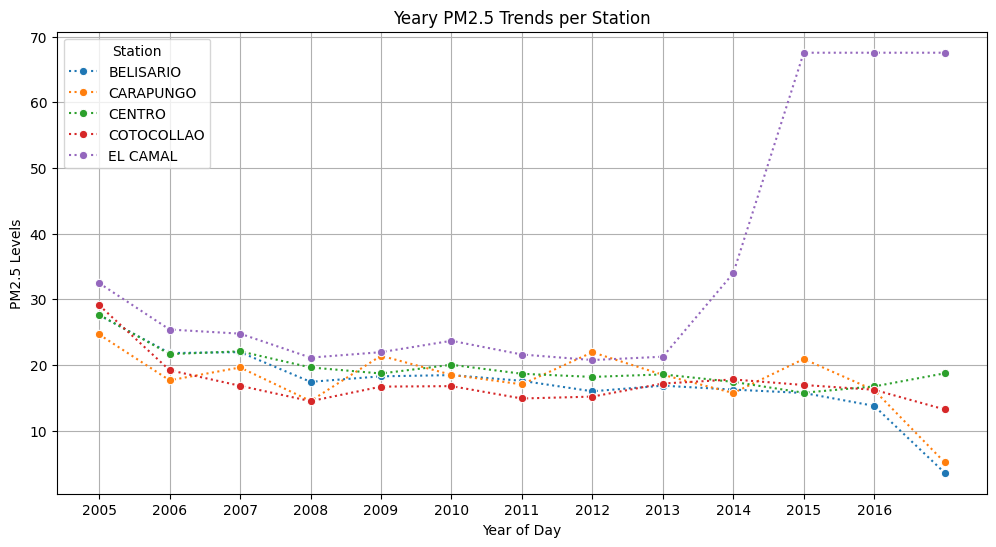

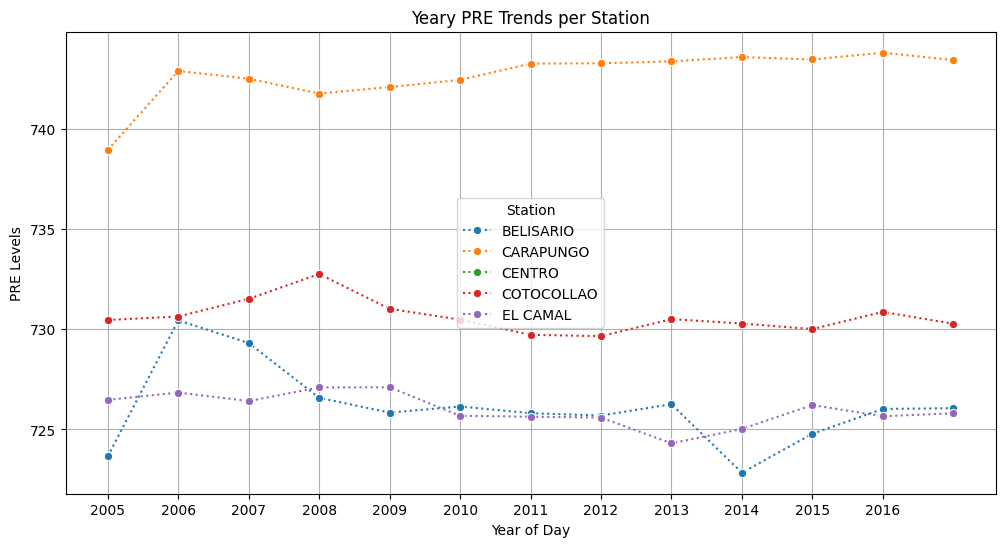

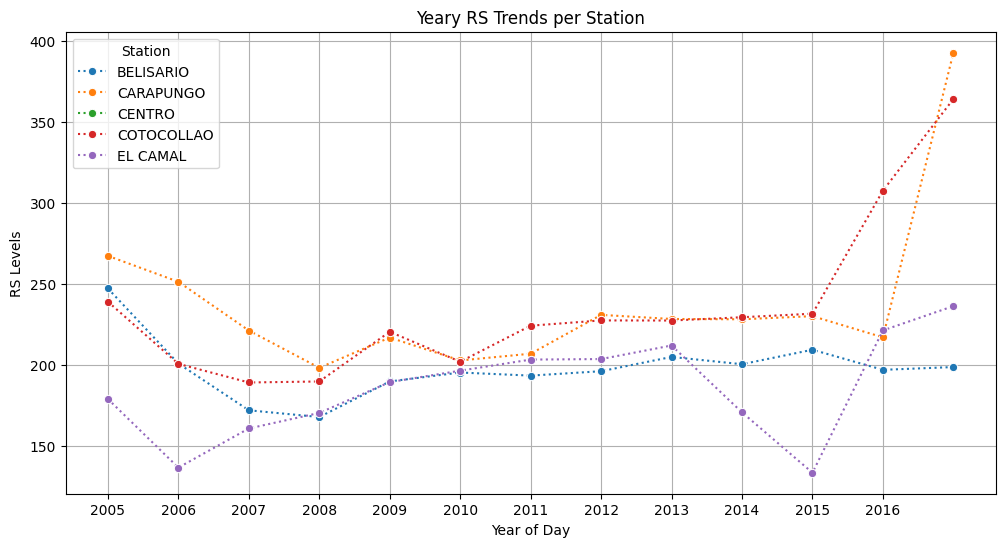

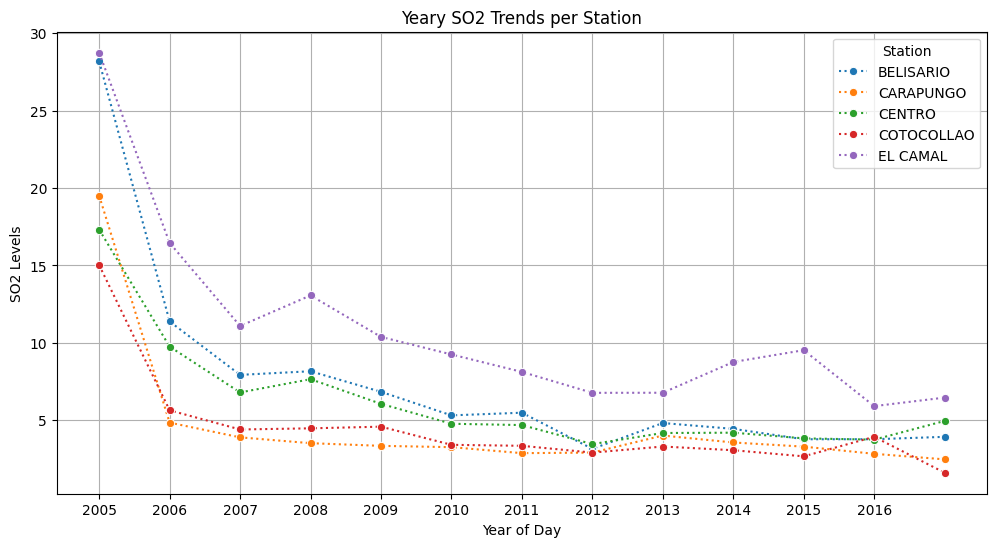

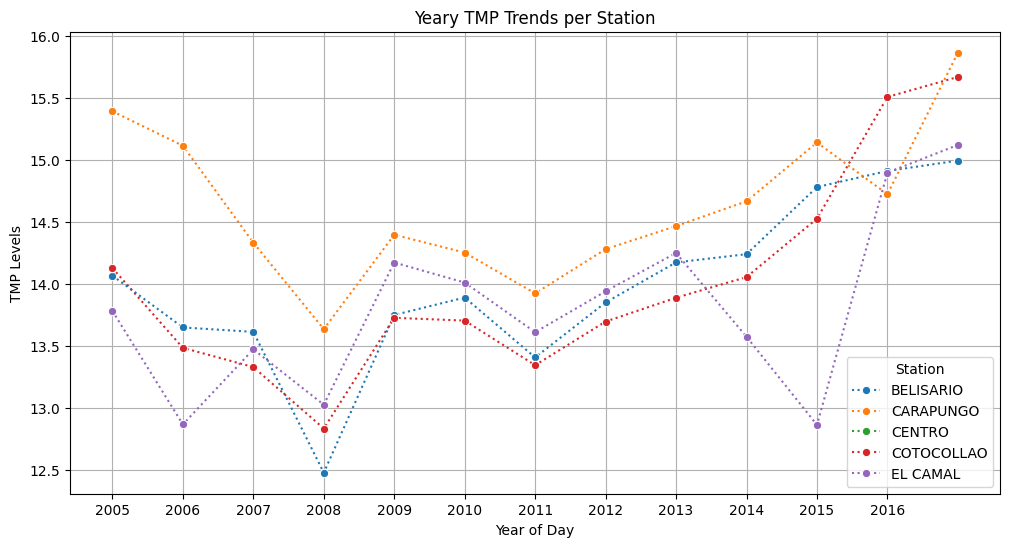

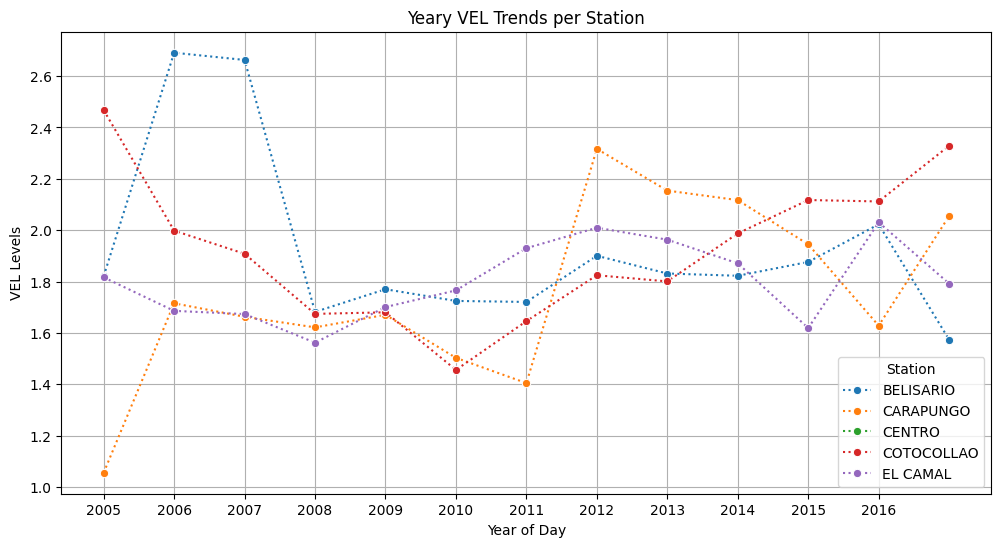

In [24]:
analysis_df = final_merged_df.copy()

# Ensure datetime index for time-based analysis
analysis_df.set_index("date", inplace=True)

# Define the selected variables for analysis
variables = ["CO", "DIR", "HUM", "NO2", "O3", "PM2.5", "PRE", "RS", "SO2", "TMP", "VEL"]

# 📌 **Hourly Trends**
analysis_df["Hour"] = analysis_df.index.hour
hourly_avg = analysis_df.groupby(["Station", "Hour"]).mean().reset_index()
for var in variables:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=hourly_avg, x="Hour", y=var, hue="Station", marker="o", linestyle="dotted")
    plt.title(f"Hourly {var} Trends per Station")
    plt.xlabel("Hour of Day")
    plt.ylabel(f"{var} Levels")
    plt.xticks(range(0, 24))
    plt.legend(title="Station")
    plt.grid()
    plt.show()

# 📌 **Seasonal Monthly Trends**
analysis_df["Month"] = analysis_df.index.month
monthly_avg = analysis_df.groupby(["Station", "Month"]).mean().reset_index()
for var in variables:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=monthly_avg, x="Month", y=var, hue="Station", marker="o", linestyle="dashdot")
    plt.title(f"Monthly {var} Trends per Station")
    plt.xlabel("Month")
    plt.ylabel(f"{var} Levels")
    plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    plt.legend(title="Station")
    plt.grid()
    plt.show()

# 📌 **Hourly Trends**
analysis_df["Year"] = analysis_df.index.year
yearly_avg = analysis_df.groupby(["Station", "Year"]).mean().reset_index()
for var in variables:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=yearly_avg, x="Year", y=var, hue="Station", marker="o", linestyle="dotted")
    plt.title(f"Yeary {var} Trends per Station")
    plt.xlabel("Year of Day")
    plt.ylabel(f"{var} Levels")
    plt.xticks(range(2005, 2017))
    plt.legend(title="Station")
    plt.grid()
    plt.show()


#### Agrupación de la data en meses

In [25]:
aggregated_station_dataframes = {}

for station, df in filtered_station_dataframes.items():
    print(f"\n🔍 Aggregating {station} - Original Shape: {df.shape}")

    # Ensure index is datetime for resampling
    df.index = pd.to_datetime(df.index, errors='coerce')

    # 1️⃣ Aggregate to Daily Data (Mean of Each Day)
    daily_df = df.resample("D").mean()
    print(f"✅ {station} - Daily Aggregation Done: {daily_df.shape}")

    # 2️⃣ Aggregate to Monthly Data (Mean of Each Month)
    monthly_df = daily_df.resample("ME").mean()
    print(f"✅ {station} - Monthly Aggregation Done: {monthly_df.shape}")

    # 3️⃣ Store monthly data for further processing
    aggregated_station_dataframes[station] = monthly_df


🔍 Aggregating BELISARIO - Original Shape: (91889, 11)
✅ BELISARIO - Daily Aggregation Done: (4534, 11)
✅ BELISARIO - Monthly Aggregation Done: (149, 11)

🔍 Aggregating CARAPUNGO - Original Shape: (91889, 10)
✅ CARAPUNGO - Daily Aggregation Done: (4534, 10)
✅ CARAPUNGO - Monthly Aggregation Done: (149, 10)

🔍 Aggregating CENTRO - Original Shape: (91889, 4)
✅ CENTRO - Daily Aggregation Done: (4534, 4)
✅ CENTRO - Monthly Aggregation Done: (149, 4)

🔍 Aggregating COTOCOLLAO - Original Shape: (91889, 10)
✅ COTOCOLLAO - Daily Aggregation Done: (4534, 10)
✅ COTOCOLLAO - Monthly Aggregation Done: (149, 10)

🔍 Aggregating EL CAMAL - Original Shape: (91889, 10)
✅ EL CAMAL - Daily Aggregation Done: (4534, 10)
✅ EL CAMAL - Monthly Aggregation Done: (149, 10)


#### Rolling statistics

In [26]:
# Define rolling window size (e.g., 3-month rolling average)
rolling_window = 3  

# Dictionary to store rolling statistics DataFrames
rolling_station_dataframes = {}

for station, df in aggregated_station_dataframes.items():
    print(f"\n🔍 Computing Rolling Statistics for {station} - Original Shape: {df.shape}")

    # Ensure datetime index
    df.index = pd.to_datetime(df.index, errors='coerce')

    # Identify the target variable (assuming 'PM2.5' as an example)
    target_var = "PM2.5"
    
    # Separate target variable from features
    feature_columns = df.columns.difference([target_var])
    
    # Compute rolling mean and rolling standard deviation only for features
    rolling_mean = df[feature_columns].rolling(window=rolling_window, min_periods=1).mean()
    rolling_std = df[feature_columns].rolling(window=rolling_window, min_periods=1).std()

    # Rename rolling mean and std columns
    rolling_mean = rolling_mean.add_suffix("_rolling_mean")
    rolling_std = rolling_std.add_suffix("_rolling_std")

    # Combine original data + rolling statistics
    rolling_df = pd.concat([df, rolling_mean, rolling_std], axis=1)

    # Store rolling statistics DataFrame
    rolling_station_dataframes[station] = rolling_df

    print(f"✅ {station} - Rolling Stats Computed - Final Shape: {rolling_df.shape}")


🔍 Computing Rolling Statistics for BELISARIO - Original Shape: (149, 11)
✅ BELISARIO - Rolling Stats Computed - Final Shape: (149, 31)

🔍 Computing Rolling Statistics for CARAPUNGO - Original Shape: (149, 10)
✅ CARAPUNGO - Rolling Stats Computed - Final Shape: (149, 28)

🔍 Computing Rolling Statistics for CENTRO - Original Shape: (149, 4)
✅ CENTRO - Rolling Stats Computed - Final Shape: (149, 10)

🔍 Computing Rolling Statistics for COTOCOLLAO - Original Shape: (149, 10)
✅ COTOCOLLAO - Rolling Stats Computed - Final Shape: (149, 28)

🔍 Computing Rolling Statistics for EL CAMAL - Original Shape: (149, 10)
✅ EL CAMAL - Rolling Stats Computed - Final Shape: (149, 28)


### 2.3 Modelos Estadísticos y de Aprendizaje Automático

#### 2.3.1 Modelo ARIMAX

El modelo ARIMAX (Autoregressive Integrated Moving Average with Exogenous Variables) es una extensión del modelo ARIMA. Este modelo combina tres componentes:

AR (Autoregresivo): Utiliza valores pasados de la serie temporal para realizar pronósticos.

I (Integrado): Representa el número de diferencias necesarias para hacer la serie estacionaria.

MA (Media móvil): Modela el error como una combinación lineal de errores pasados.

El ARIMAX añade variables exógenas, que son factores externos que influyen en la serie temporal, mejorando así la precisión del modelo.

In [27]:
# Function to check stationarity
def check_stationarity(df, variable):
    result = adfuller(df[variable].dropna())
    print(f"ADF Statistic for {variable}: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("Data is non-stationary. Differencing is needed.")
    else:
        print("Data is stationary.")

# Ensure stationarity in data
for station, df in rolling_station_dataframes.items():
    df.index = pd.to_datetime(df.index, errors='coerce')
    
    # 1️⃣ Select only rolling mean columns (avoid std & original values)
    rolling_mean_cols = [col for col in df.columns if "_rolling_mean" in col]
    df = df[rolling_mean_cols]

    # 2️⃣ Check stationarity for each rolling mean variable
    for col in df.columns:
        print(f"\n📊 Checking stationarity for {station} - {col}")
        check_stationarity(df, col)


📊 Checking stationarity for BELISARIO - CO_rolling_mean
ADF Statistic for CO_rolling_mean: -2.691675240991258
p-value: 0.07548992743957213
Data is non-stationary. Differencing is needed.

📊 Checking stationarity for BELISARIO - DIR_rolling_mean
ADF Statistic for DIR_rolling_mean: -2.605788148582159
p-value: 0.09180686614994854
Data is non-stationary. Differencing is needed.

📊 Checking stationarity for BELISARIO - HUM_rolling_mean
ADF Statistic for HUM_rolling_mean: -0.5686960523485228
p-value: 0.8778997218116592
Data is non-stationary. Differencing is needed.

📊 Checking stationarity for BELISARIO - NO2_rolling_mean
ADF Statistic for NO2_rolling_mean: -0.9341823912483741
p-value: 0.7765073929683315
Data is non-stationary. Differencing is needed.

📊 Checking stationarity for BELISARIO - O3_rolling_mean
ADF Statistic for O3_rolling_mean: -1.9084447930205637
p-value: 0.3280989019128089
Data is non-stationary. Differencing is needed.

📊 Checking stationarity for BELISARIO - PRE_rolling_m

In [28]:
def make_stationary(df, variable):
    result = adfuller(df[variable].dropna())
    p_value = result[1]
    
    if p_value > 0.05:
        df[variable] = df[variable].diff().dropna()
        print(f"📉 Applied first-order differencing for {variable}")

    return df

# Apply stationarity transformation
stationary_dataframes = {}

for station, df in rolling_station_dataframes.items():
    print(f"\n🔍 Processing station: {station}")

    # Convert index to datetime
    df.index = pd.to_datetime(df.index, errors='coerce')

    # Apply differencing to necessary variables
    for col in df.columns:
        df = make_stationary(df, col)
    
    stationary_dataframes[station] = df

print("\n✅ Data has been transformed for stationarity")


🔍 Processing station: BELISARIO
📉 Applied first-order differencing for HUM
📉 Applied first-order differencing for NO2
📉 Applied first-order differencing for O3
📉 Applied first-order differencing for PM2.5
📉 Applied first-order differencing for VEL
📉 Applied first-order differencing for CO_rolling_mean
📉 Applied first-order differencing for DIR_rolling_mean
📉 Applied first-order differencing for HUM_rolling_mean
📉 Applied first-order differencing for NO2_rolling_mean
📉 Applied first-order differencing for O3_rolling_mean
📉 Applied first-order differencing for PRE_rolling_mean
📉 Applied first-order differencing for RS_rolling_mean
📉 Applied first-order differencing for TMP_rolling_mean
📉 Applied first-order differencing for VEL_rolling_mean
📉 Applied first-order differencing for HUM_rolling_std
📉 Applied first-order differencing for NO2_rolling_std
📉 Applied first-order differencing for O3_rolling_std

🔍 Processing station: CARAPUNGO
📉 Applied first-order differencing for DIR
📉 Applied 

In [29]:
# Forecasting parameters
forecast_horizon_5y = 5 * 12
forecast_horizon_10y = 10 * 12

arimax_forecasts = {}

for station, df in stationary_dataframes.items():
    print(f"\n🔍 Training ARIMAX Model for {station}")

    df.dropna(inplace=True)  # Ensure no NaNs

    # Select the target variable (PM2.5 as an example)
    target_var = 'PM2.5'
    if target_var not in df.columns:
        print(f"⚠️ Skipping {station} - {target_var} not found")
        continue

    # Use exogenous variables (excluding the target)
    exog_vars = df.drop(columns=[target_var], errors='ignore')

    # Fit ARIMAX model
    model = sm.tsa.ARIMA(df[target_var], exog=exog_vars, order=(2,1,2), seasonal_order=(1,1,1,12))
    fitted_model = model.fit()

    # Forecast next 5 and 10 years
    forecast_5y = fitted_model.forecast(steps=forecast_horizon_5y, exog=exog_vars.iloc[-forecast_horizon_5y:])
    forecast_10y = fitted_model.forecast(steps=forecast_horizon_10y, exog=exog_vars.iloc[-forecast_horizon_10y:])

    # Save results
    arimax_forecasts[station] = {
        "5_years": forecast_5y,
        "10_years": forecast_10y
    }

    print(f"✅ {station} - ARIMAX Model Trained and Forecast Completed")


🔍 Training ARIMAX Model for BELISARIO


c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

✅ BELISARIO - ARIMAX Model Trained and Forecast Completed

🔍 Training ARIMAX Model for CARAPUNGO


c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results wi

✅ CARAPUNGO - ARIMAX Model Trained and Forecast Completed

🔍 Training ARIMAX Model for CENTRO


c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results wi

✅ CENTRO - ARIMAX Model Trained and Forecast Completed

🔍 Training ARIMAX Model for COTOCOLLAO


c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results wi

✅ COTOCOLLAO - ARIMAX Model Trained and Forecast Completed

🔍 Training ARIMAX Model for EL CAMAL
✅ EL CAMAL - ARIMAX Model Trained and Forecast Completed


c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\xavir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results wi

C:\Users\xavir\AppData\Local\Temp\ipykernel_47156\3461732108.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=df.index[-1], periods=forecast_horizon_5y, freq='M'), arimax_forecasts[station]["5_years"], label="ARIMAX 5Y Forecast", linestyle="--", color="red")
C:\Users\xavir\AppData\Local\Temp\ipykernel_47156\3461732108.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=df.index[-1], periods=forecast_horizon_10y, freq='M'), arimax_forecasts[station]["10_years"], label="ARIMAX 10Y Forecast", linestyle="--", color="orange")


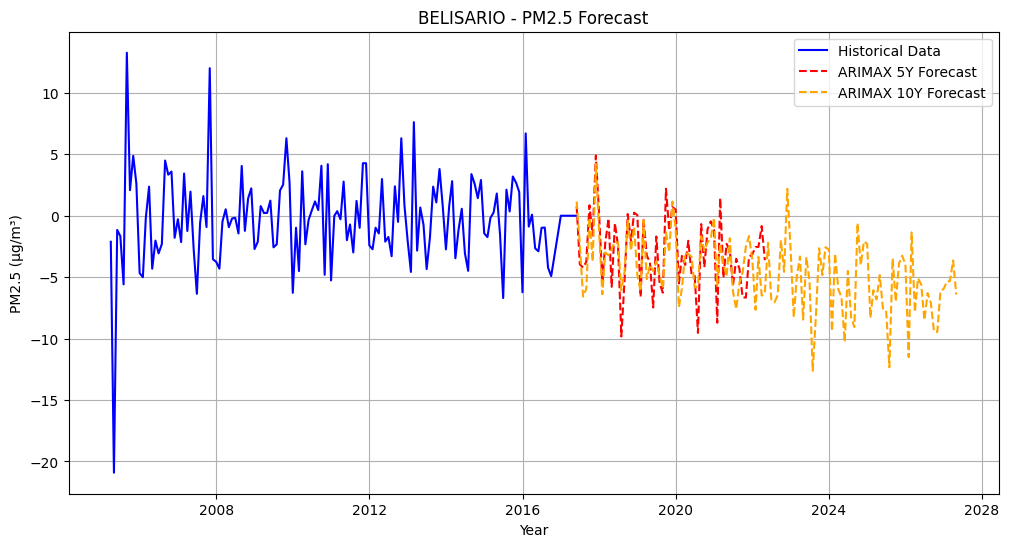

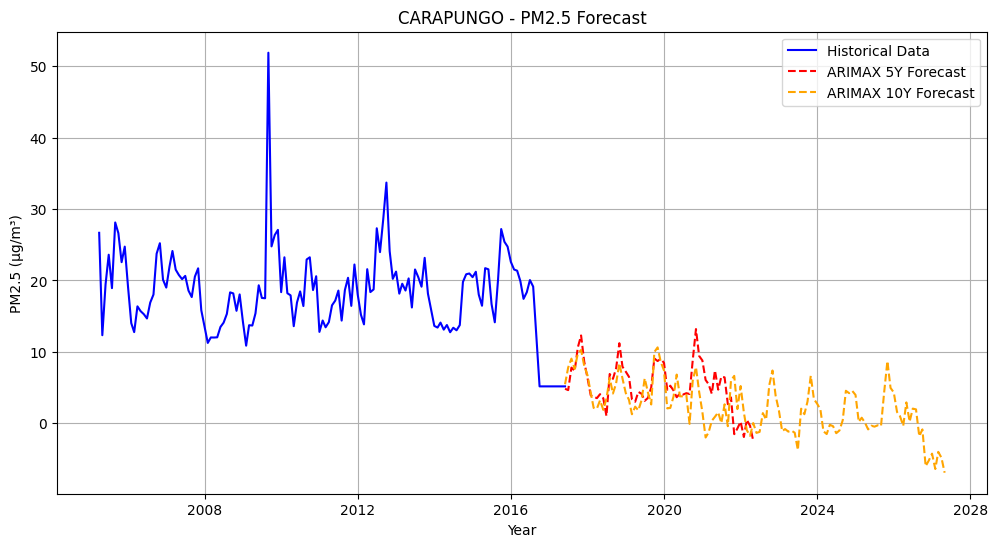

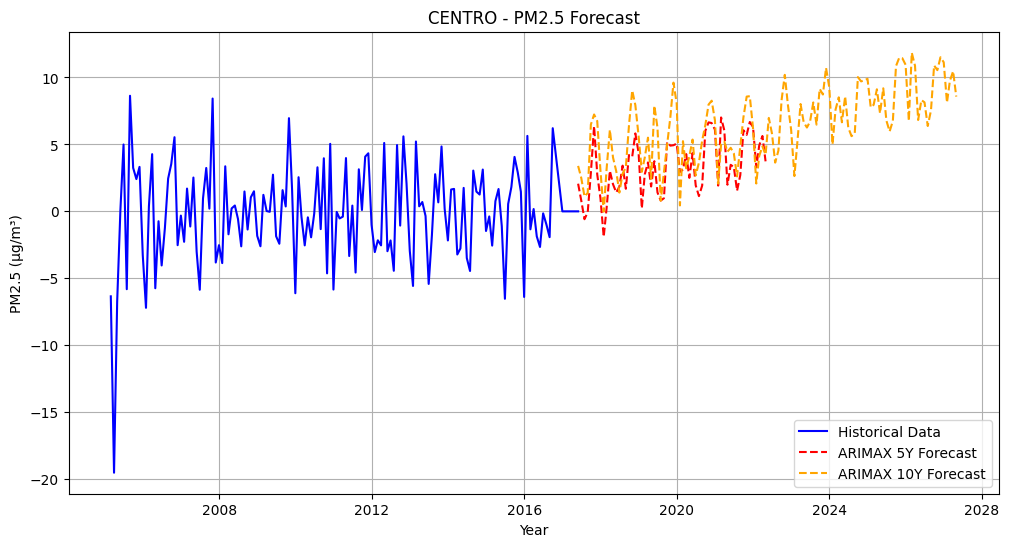

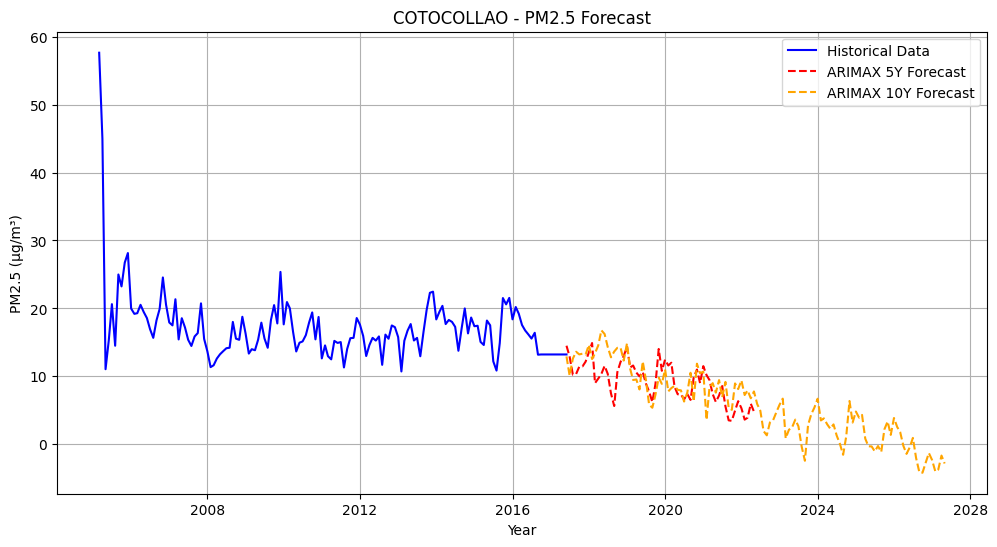

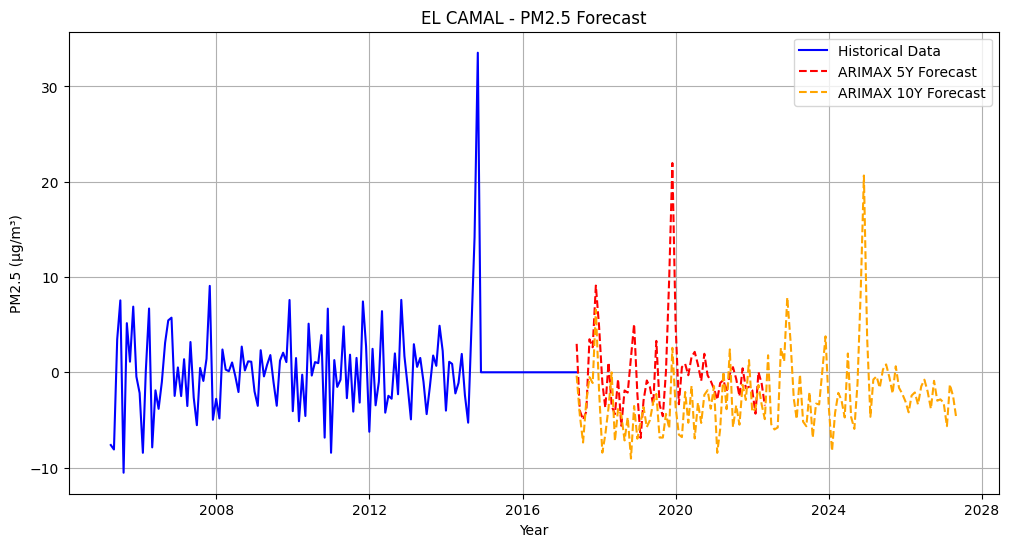

In [30]:
for station in stationary_dataframes.keys():
    plt.figure(figsize=(12, 6))

    # Plot historical data
    plt.plot(stationary_dataframes[station].index, stationary_dataframes[station]['PM2.5'], label="Historical Data", color="blue")

    # Plot ARIMAX forecasts
    plt.plot(pd.date_range(start=df.index[-1], periods=forecast_horizon_5y, freq='M'), arimax_forecasts[station]["5_years"], label="ARIMAX 5Y Forecast", linestyle="--", color="red")
    plt.plot(pd.date_range(start=df.index[-1], periods=forecast_horizon_10y, freq='M'), arimax_forecasts[station]["10_years"], label="ARIMAX 10Y Forecast", linestyle="--", color="orange")

    plt.title(f"{station} - PM2.5 Forecast")
    plt.xlabel("Year")
    plt.ylabel("PM2.5 (µg/m³)")
    plt.legend()
    plt.grid()
    plt.show()


#### 2.3.2 Algoritmo Random Forest

El Random Forest es un algoritmo de aprendizaje automático basado en la combinación de múltiples árboles de decisión. Cada árbol se entrena con un subconjunto diferente de los datos, y el resultado final es el promedio de las predicciones individuales.

Ventajas del Random Forest:

Es robusto frente a datos ruidosos.

Puede manejar relaciones no lineales entre las variables.

Reduce el riesgo de sobreajuste (“overfitting”) mediante el uso de árboles múltiples.

In [31]:
# Forecasting horizon (5 and 10 years)
forecast_horizon_5y = 5 * 12
forecast_horizon_10y = 10 * 12

ml_forecasts = {}

for station, df in rolling_station_dataframes.items():
    print(f"\n🔍 Training ML Model for {station}")

    # Ensure datetime index
    df.index = pd.to_datetime(df.index, errors='coerce')

    # Identify the target variable
    target_var = "PM2.5"  # Change if needed
    if target_var not in df.columns:
        print(f"⚠️ Skipping {station} - {target_var} not found")
        continue

    # Separate rolling features & original features
    feature_columns = df.columns.difference([target_var])
    
    # Keep all features (original + rolling mean & std)
    X = df[feature_columns].copy()
    y = df[target_var].copy()

    # Create lag features (past values as predictors)
    for lag in range(1, 13):  # Use past 12 months
        X[f'lag_{lag}'] = y.shift(lag)

    X.dropna(inplace=True)  # Drop NaNs from shifting

    # Align target variable
    y = y.loc[X.index]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train ML Model (Random Forest)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Prepare future data for predictions
    future_X = X.iloc[-forecast_horizon_10y:].copy()  # Use last known data
    
    # Forecast next 5 and 10 years
    forecast_5y = model.predict(future_X[:forecast_horizon_5y])
    forecast_10y = model.predict(future_X)

    # Save results
    ml_forecasts[station] = {
        "5_years": forecast_5y,
        "10_years": forecast_10y
    }

    print(f"✅ {station} - ML Forecast Completed")



🔍 Training ML Model for BELISARIO
✅ BELISARIO - ML Forecast Completed

🔍 Training ML Model for CARAPUNGO
✅ CARAPUNGO - ML Forecast Completed

🔍 Training ML Model for CENTRO
✅ CENTRO - ML Forecast Completed

🔍 Training ML Model for COTOCOLLAO
✅ COTOCOLLAO - ML Forecast Completed

🔍 Training ML Model for EL CAMAL
✅ EL CAMAL - ML Forecast Completed


C:\Users\xavir\AppData\Local\Temp\ipykernel_47156\4194984263.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates_5y = pd.date_range(start=df.index[-1], periods=forecast_horizon_5y, freq='M')
C:\Users\xavir\AppData\Local\Temp\ipykernel_47156\4194984263.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates_10y = pd.date_range(start=df.index[-1], periods=forecast_horizon_10y, freq='M')


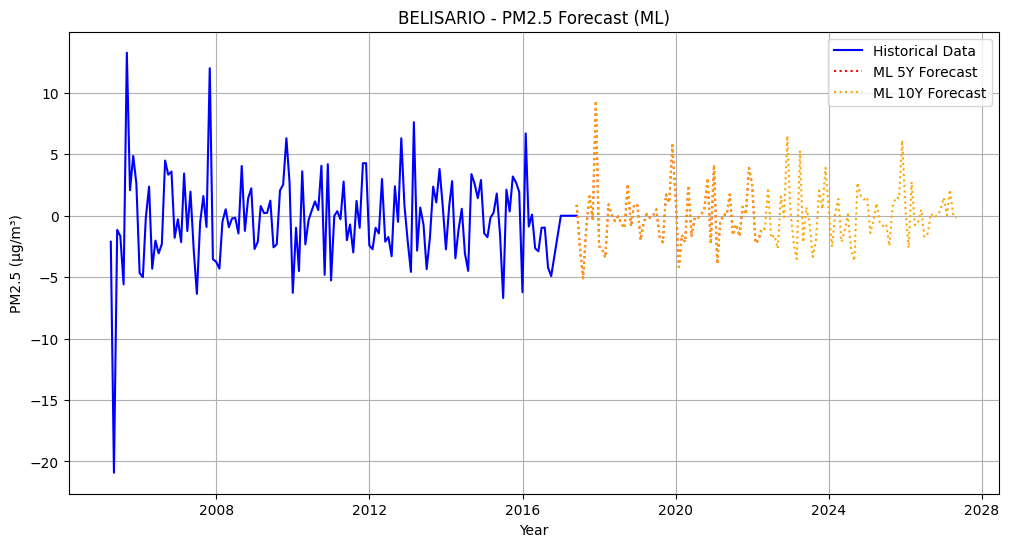

C:\Users\xavir\AppData\Local\Temp\ipykernel_47156\4194984263.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates_5y = pd.date_range(start=df.index[-1], periods=forecast_horizon_5y, freq='M')
C:\Users\xavir\AppData\Local\Temp\ipykernel_47156\4194984263.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates_10y = pd.date_range(start=df.index[-1], periods=forecast_horizon_10y, freq='M')


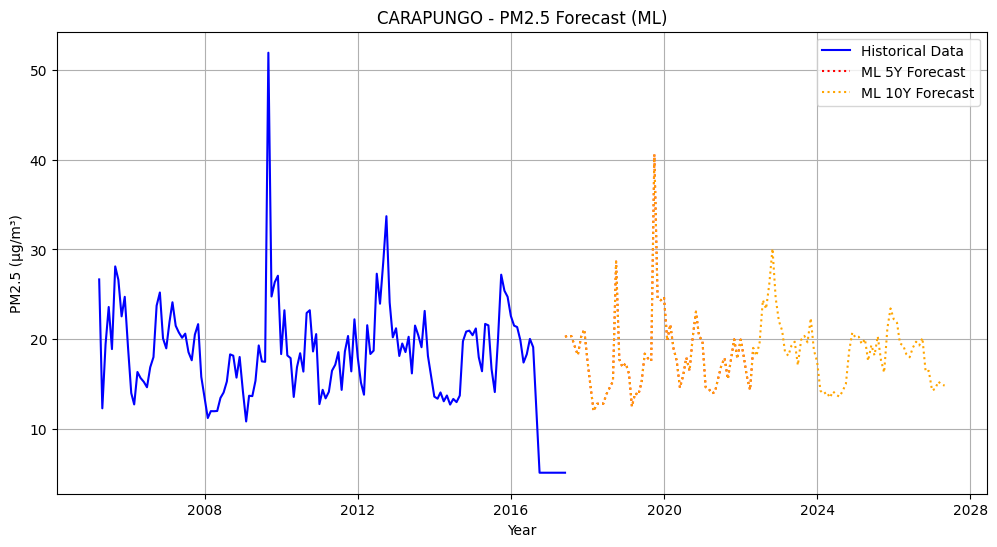

C:\Users\xavir\AppData\Local\Temp\ipykernel_47156\4194984263.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates_5y = pd.date_range(start=df.index[-1], periods=forecast_horizon_5y, freq='M')
C:\Users\xavir\AppData\Local\Temp\ipykernel_47156\4194984263.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates_10y = pd.date_range(start=df.index[-1], periods=forecast_horizon_10y, freq='M')


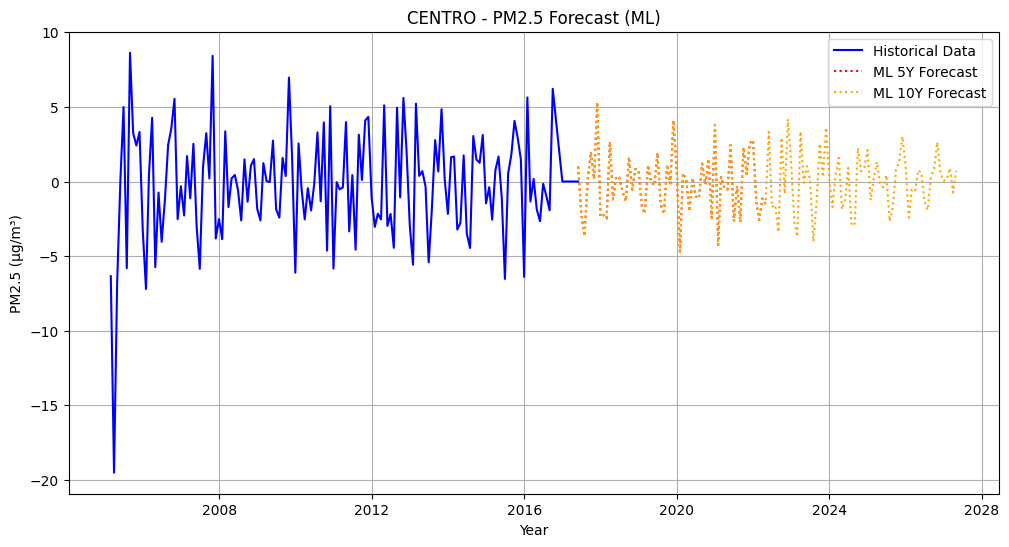

C:\Users\xavir\AppData\Local\Temp\ipykernel_47156\4194984263.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates_5y = pd.date_range(start=df.index[-1], periods=forecast_horizon_5y, freq='M')
C:\Users\xavir\AppData\Local\Temp\ipykernel_47156\4194984263.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates_10y = pd.date_range(start=df.index[-1], periods=forecast_horizon_10y, freq='M')


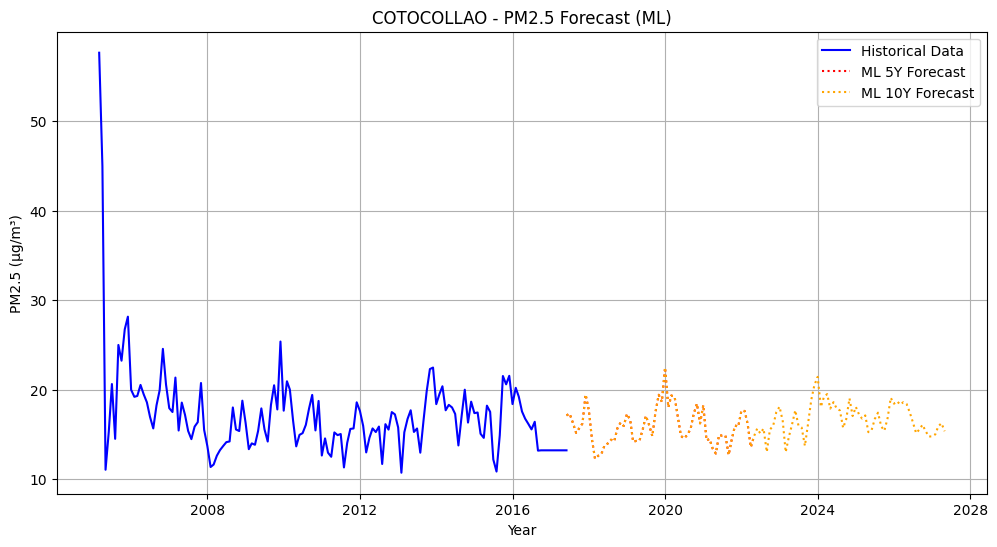

C:\Users\xavir\AppData\Local\Temp\ipykernel_47156\4194984263.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates_5y = pd.date_range(start=df.index[-1], periods=forecast_horizon_5y, freq='M')
C:\Users\xavir\AppData\Local\Temp\ipykernel_47156\4194984263.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates_10y = pd.date_range(start=df.index[-1], periods=forecast_horizon_10y, freq='M')


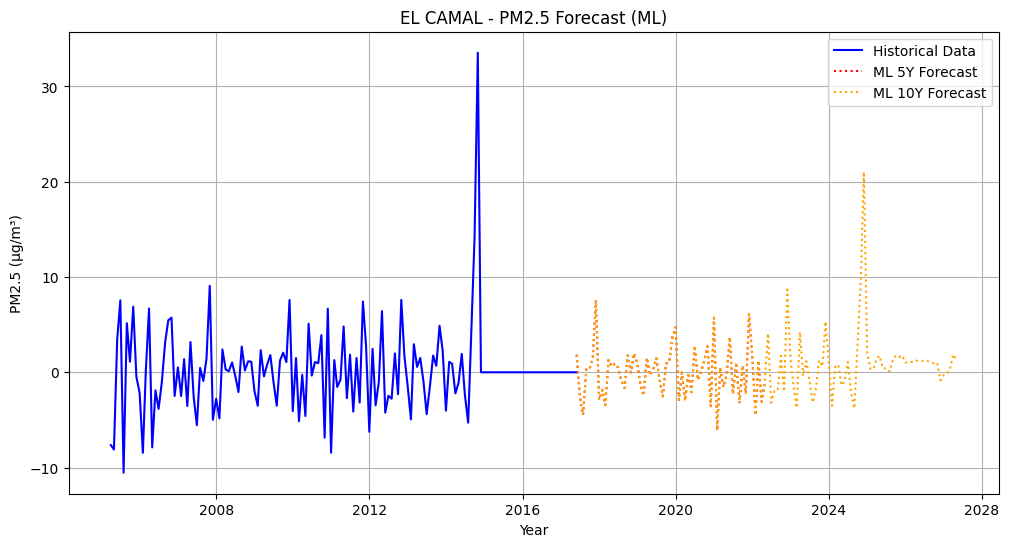

In [32]:
import matplotlib.pyplot as plt

# Define forecast horizon (months)
forecast_horizon_5y = 5 * 12  # 5 years (monthly data)
forecast_horizon_10y = 10 * 12  # 10 years (monthly data)

for station in ml_forecasts.keys():
    plt.figure(figsize=(12, 6))

    # Get historical data
    df = stationary_dataframes[station]
    df.index = pd.to_datetime(df.index)

    # Plot historical data
    plt.plot(df.index, df['PM2.5'], label="Historical Data", color="blue")

    # Define forecast dates
    forecast_dates_5y = pd.date_range(start=df.index[-1], periods=forecast_horizon_5y, freq='M')
    forecast_dates_10y = pd.date_range(start=df.index[-1], periods=forecast_horizon_10y, freq='M')

    # Plot ML Forecasts
    plt.plot(forecast_dates_5y, ml_forecasts[station]["5_years"], label="ML 5Y Forecast", linestyle="dotted", color="red")
    plt.plot(forecast_dates_10y, ml_forecasts[station]["10_years"], label="ML 10Y Forecast", linestyle="dotted", color="orange")

    plt.title(f"{station} - PM2.5 Forecast (ML)")
    plt.xlabel("Year")
    plt.ylabel("PM2.5 (µg/m³)")
    plt.legend()
    plt.grid()
    plt.show()


#### 2.3.3 Validación de Modelos

Para evaluar el rendimiento de los modelos, se emplean técnicas como la división de los datos en conjuntos de entrenamiento y prueba. Además, se utilizan métricas de error como el error cuadrático medio (RMSE) y el error absoluto medio (MAE).

In [33]:
arimax_rmse = {}

for station, df in stationary_dataframes.items():
    print(f"\n📊 Evaluating ARIMAX Model for {station}")

    # Ensure datetime format
    df.index = pd.to_datetime(df.index)

    # Define actual values for comparison
    actual_5y = df['PM2.5'].iloc[-60:]  # Last 5 years
    actual_10y = df['PM2.5'].iloc[-120:]  # Last 10 years

    # Ensure forecast data exists
    if station not in arimax_forecasts:
        print(f"⚠️ Skipping {station} - No ARIMAX forecast available")
        continue

    forecast_5y = arimax_forecasts[station]["5_years"]
    forecast_10y = arimax_forecasts[station]["10_years"]

    # Compute RMSE for 5 and 10 years
    rmse_5y = np.sqrt(mean_squared_error(actual_5y, forecast_5y[:60]))
    rmse_10y = np.sqrt(mean_squared_error(actual_10y, forecast_10y[:120]))

    # Save RMSE results
    arimax_rmse[station] = {"5_years_RMSE": rmse_5y, "10_years_RMSE": rmse_10y}

    print(f"✅ {station} - ARIMAX RMSE (5Y): {rmse_5y:.3f}, (10Y): {rmse_10y:.3f}")



📊 Evaluating ARIMAX Model for BELISARIO
✅ BELISARIO - ARIMAX RMSE (5Y): 3.211, (10Y): 5.053

📊 Evaluating ARIMAX Model for CARAPUNGO
✅ CARAPUNGO - ARIMAX RMSE (5Y): 13.156, (10Y): 16.294

📊 Evaluating ARIMAX Model for CENTRO
✅ CENTRO - ARIMAX RMSE (5Y): 4.285, (10Y): 7.196

📊 Evaluating ARIMAX Model for COTOCOLLAO
✅ COTOCOLLAO - ARIMAX RMSE (5Y): 7.750, (10Y): 11.840

📊 Evaluating ARIMAX Model for EL CAMAL
✅ EL CAMAL - ARIMAX RMSE (5Y): 2.823, (10Y): 4.369


In [34]:
ml_rmse = {}

for station in ml_forecasts.keys():
    print(f"\n📊 Evaluating ML Model for {station}")

    # Get the actual historical data from stationary_dataframes
    df = stationary_dataframes[station]
    df.index = pd.to_datetime(df.index)

    # Define actual values for comparison
    actual_5y = df['PM2.5'].iloc[-60:]  # Last 5 years
    actual_10y = df['PM2.5'].iloc[-120:]  # Last 10 years

    # Ensure forecast data exists
    if station not in ml_forecasts:
        print(f"⚠️ Skipping {station} - No ML forecast available")
        continue

    # Extract forecasted values
    forecast_5y = ml_forecasts[station]["5_years"]
    forecast_10y = ml_forecasts[station]["10_years"]

    # Ensure forecasts match actual data length
    forecast_5y = forecast_5y[:len(actual_5y)]
    forecast_10y = forecast_10y[:len(actual_10y)]

    # Compute RMSE for 5 and 10 years
    rmse_5y = np.sqrt(mean_squared_error(actual_5y, forecast_5y))
    rmse_10y = np.sqrt(mean_squared_error(actual_10y, forecast_10y))

    # Save RMSE results
    ml_rmse[station] = {"5_years_RMSE": rmse_5y, "10_years_RMSE": rmse_10y}

    print(f"✅ {station} - ML RMSE (5Y): {rmse_5y:.3f}, (10Y): {rmse_10y:.3f}")


📊 Evaluating ML Model for BELISARIO
✅ BELISARIO - ML RMSE (5Y): 2.740, (10Y): 1.355

📊 Evaluating ML Model for CARAPUNGO
✅ CARAPUNGO - ML RMSE (5Y): 7.326, (10Y): 3.240

📊 Evaluating ML Model for CENTRO
✅ CENTRO - ML RMSE (5Y): 2.670, (10Y): 1.473

📊 Evaluating ML Model for COTOCOLLAO
✅ COTOCOLLAO - ML RMSE (5Y): 3.097, (10Y): 1.354

📊 Evaluating ML Model for EL CAMAL
✅ EL CAMAL - ML RMSE (5Y): 4.961, (10Y): 1.664


In [36]:
# Combine RMSE results into a DataFrame
rmse_df = pd.DataFrame.from_dict(arimax_rmse, orient='index')
rmse_df.columns = ['ARIMAX_5Y_RMSE', 'ARIMAX_10Y_RMSE']

ml_rmse_df = pd.DataFrame.from_dict(ml_rmse, orient='index')
ml_rmse_df.columns = ['ML_5Y_RMSE', 'ML_10Y_RMSE']

# Merge ARIMAX and ML RMSE results
rmse_comparison = pd.concat([rmse_df, ml_rmse_df], axis=1)

# Display RMSE comparison
rmse_comparison

ARIMAX_5Y_RMSE  ARIMAX_10Y_RMSE  ML_5Y_RMSE  ML_10Y_RMSE
BELISARIO         3.210928         5.053064    2.740100     1.355495
CARAPUNGO        13.155723        16.294056    7.325682     3.240194
CENTRO            4.284973         7.195721    2.669650     1.472882
COTOCOLLAO        7.750364        11.840035    3.096814     1.354249
EL CAMAL          2.823319         4.368583    4.960906     1.664231